# Sharks from Space

## AI Model creations

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import joblib
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (LSTM, Dense, Input, Dropout, BatchNormalization,
                                   Conv1D, MaxPooling1D, Flatten, GRU, Bidirectional)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model creation

In [2]:
# Configuración GPU para máximo rendimiento
def configure_gpu():
    """Configura la GPU para máximo rendimiento en Google Colab"""
    print("🔧 Configurando GPU...")

    # Verificar disponibilidad de GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Configurar crecimiento de memoria
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Configuración de estrategia
            strategy = tf.distribute.MirroredStrategy()
            print(f'✅ {len(gpus)} GPU(s) disponibles')
            print(f'🎯 Estrategia: {strategy}')

            # Configurar TensorFlow para usar GPU
            tf.config.optimizer.set_jit(True)  # XLA compilation
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("🚀 Configuración GPU completada: Mixed Precision + XLA")

            return strategy

        except RuntimeError as e:
            print(f'❌ Error configurando GPU: {e}')
            return None
    else:
        print('❌ No se encontraron GPUs, usando CPU')
        return None

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

class TrueTemporalSharkPipeline:
    def __init__(self, k=7, sequence_length=6, drive_path='/content/drive/MyDrive/NASA Space Apps/results'):
        self.k = k
        self.sequence_length = sequence_length  # MESES anteriores a considerar
        self.drive_path = drive_path
        self.model = None
        self.scaler = StandardScaler()
        self.le = LabelEncoder()
        self.w_k = None
        self.history = None
        self.cv_scores = []
        self.model_version = "2.0.0"  # Nueva versión con análisis temporal real
        self.training_date = None
        self.strategy = configure_gpu()
        self.temporal_features = None

    def load_data_from_drive(self, file_pattern="*.csv"):
        """
        Carga dinámica de todos los archivos CSV desde Google Drive
        """
        print("🔍 Buscando archivos CSV en Google Drive...")

        # Buscar archivos CSV en la carpeta
        search_path = os.path.join(self.drive_path, file_pattern)
        csv_files = glob.glob(search_path)

        if not csv_files:
            raise FileNotFoundError(f"No se encontraron archivos CSV en {search_path}")

        print(f"📁 Encontrados {len(csv_files)} archivos:")
        for file in csv_files:
            print(f"   - {os.path.basename(file)}")

        # Cargar y combinar todos los datos
        all_data = []
        for file_path in csv_files:
            try:
                df_month = pd.read_csv(file_path)
                # Verificar que tenga las columnas necesarias
                required_columns = ['lat', 'lon', 'cluster', 'month', 'year']
                if all(col in df_month.columns for col in required_columns):
                    all_data.append(df_month)
                    print(f"✅ {os.path.basename(file_path)}: {len(df_month)} registros")
                else:
                    print(f"❌ {os.path.basename(file_path)}: Columnas faltantes")
            except Exception as e:
                print(f"❌ Error cargando {file_path}: {e}")

        if not all_data:
            raise ValueError("No se pudieron cargar datos válidos")

        # Combinar todos los datos
        full_df = pd.concat(all_data, ignore_index=True)
        full_df = full_df.sort_values(['year', 'month', 'lat', 'lon']).reset_index(drop=True)

        print(f"\n📊 Dataset completo: {len(full_df)} registros")
        print(f"📅 Rango temporal: {full_df['year'].min()}-{full_df['year'].max()}")
        print(f"🎯 Clusters únicos: {sorted(full_df['cluster'].unique())}")

        return full_df

    def create_temporal_sequences(self, df):
        """
        Crea VERDADERAS secuencias temporales para cada ubicación (lat, lon)
        """
        print("🕰️ Creando secuencias temporales REALES...")

        # Ordenar por ubicación y tiempo
        df_sorted = df.sort_values(['lat', 'lon', 'year', 'month']).copy()

        sequences = []
        next_clusters = []
        locations = []

        # Agrupar por ubicación única
        unique_locations = df_sorted[['lat', 'lon']].drop_duplicates()

        for _, loc in unique_locations.iterrows():
            lat, lon = loc['lat'], loc['lon']
            location_data = df_sorted[
                (df_sorted['lat'] == lat) & (df_sorted['lon'] == lon)
            ].sort_values(['year', 'month']).copy()

            if len(location_data) < self.sequence_length + 1:
                continue

            # Crear secuencias deslizantes para esta ubicación
            for i in range(len(location_data) - self.sequence_length):
                # Secuencia de meses consecutivos
                sequence = location_data.iloc[i:i + self.sequence_length]
                target = location_data.iloc[i + self.sequence_length]

                # Características temporales avanzadas
                seq_features = self.extract_temporal_features(sequence, target)

                sequences.append(seq_features)
                next_clusters.append(target['cluster'])
                locations.append((lat, lon, target['year'], target['month']))

        print(f"📊 Secuencias temporales creadas: {len(sequences)}")
        return np.array(sequences), np.array(next_clusters), locations

    def extract_temporal_features(self, sequence, target):
        """
        Extrae características temporales avanzadas de una secuencia
        """
        features = []

        # 1. HISTORIAL de clusters (secuencia temporal principal)
        cluster_history = sequence['cluster'].values
        features.extend(cluster_history)

        # 2. TENDENCIAS temporales
        months = sequence['month'].values
        years = sequence['year'].values

        # Tendencia lineal de clusters
        if len(cluster_history) > 1:
            cluster_trend = np.polyfit(range(len(cluster_history)), cluster_history, 1)[0]
        else:
            cluster_trend = 0
        features.append(cluster_trend)

        # 3. ESTACIONALIDAD avanzada
        current_month = target['month']
        current_year = target['year']

        # Características cíclicas avanzadas
        month_angle = 2 * np.pi * current_month / 12
        features.extend([np.sin(month_angle), np.cos(month_angle)])

        # Estación del año (hemisferio sur)
        season = (current_month % 12 + 3) // 3
        features.extend([np.sin(2*np.pi*season/4), np.cos(2*np.pi*season/4)])

        # 4. CAMBIOS y VELOCIDADES
        if len(cluster_history) > 1:
            # Velocidad de cambio (derivada primera)
            cluster_velocity = np.diff(cluster_history)
            features.extend([np.mean(cluster_velocity), np.std(cluster_velocity)])

            # Aceleración (derivada segunda)
            if len(cluster_velocity) > 1:
                cluster_acceleration = np.diff(cluster_velocity)
                features.extend([np.mean(cluster_acceleration), np.std(cluster_acceleration)])
            else:
                features.extend([0, 0])
        else:
            features.extend([0, 0, 0, 0])

        # 5. PATRONES de REPETICIÓN
        unique_clusters, counts = np.unique(cluster_history, return_counts=True)
        features.append(len(unique_clusters))  # Diversidad de clusters
        features.append(np.max(counts) if len(counts) > 0 else 0)  # Máxima frecuencia

        # 6. CARACTERÍSTICAS de POSICIÓN actual
        features.extend([target['lat'], target['lon']])

        # 7. INTERACCIONES espacio-temporales
        features.append(target['lat'] * np.sin(month_angle))
        features.append(target['lon'] * np.cos(month_angle))

        # 8. FACTOR de CONTINUIDAD
        last_cluster = cluster_history[-1] if len(cluster_history) > 0 else 0
        features.append(1 if last_cluster == target['cluster'] else 0)

        # 9. FACTOR latitudinal
        abs_lat = np.abs(target['lat'])
        lat_factor = np.exp(-0.5 * ((abs_lat - 50) / 20) ** 2)
        features.append(0.5 + 0.5 * lat_factor)

        return np.array(features, dtype=np.float32)

    def create_sequential_folds(self, sequences, targets, locations, n_splits=5):
        """
        Divide las secuencias temporales en folds respetando la cronología
        """
        print("\n🔄 Creando folds temporales para secuencias...")

        # Ordenar por tiempo usando la información de locations
        time_ids = [year * 12 + month for (_, _, year, month) in locations]
        sorted_indices = np.argsort(time_ids)

        sequences_sorted = sequences[sorted_indices]
        targets_sorted = targets[sorted_indices]

        # Time Series Split para secuencias temporales
        tscv = TimeSeriesSplit(n_splits=n_splits)

        folds = []
        for train_idx, test_idx in tscv.split(sequences_sorted):
            folds.append({
                'X_train': sequences_sorted[train_idx],
                'X_test': sequences_sorted[test_idx],
                'y_train': targets_sorted[train_idx],
                'y_test': targets_sorted[test_idx],
                'train_indices': train_idx,
                'test_indices': test_idx
            })

        # Mostrar información de los folds
        for i, fold in enumerate(folds):
            print(f"   Fold {i+1}: Train {len(fold['X_train'])} secuencias, Test {len(fold['X_test'])} secuencias")

        return folds

    def calculate_temporal_weights(self, df):
        """
        Pesos que consideran patrones TEMPORALES reales
        """
        print("⚖️ Calculando pesos TEMPORALES...")

        # 1. RAREZA TEMPORAL (clusters que aparecen en momentos específicos)
        temporal_rarity = {}
        for cluster in range(self.k):
            cluster_data = df[df['cluster'] == cluster]
            if len(cluster_data) > 0:
                # Entropía de la distribución mensual (baja entropía = más raro)
                month_probs = cluster_data['month'].value_counts(normalize=True)
                entropy = -np.sum(month_probs * np.log(month_probs + 1e-10))
                temporal_rarity[cluster] = 1 - (entropy / np.log(12))  # Normalizar
            else:
                temporal_rarity[cluster] = 1.0  # Máxima rareza

        # 2. PERSISTENCIA TEMPORAL
        persistence_weights = {}
        for cluster in range(self.k):
            persistence = self.calculate_cluster_persistence(df, cluster)
            persistence_weights[cluster] = persistence

        # 3. ESTACIONALIDAD
        seasonal_weights = {}
        high_season_months = [11, 12, 1, 2, 3]  # Primavera/Verano
        for cluster in range(self.k):
            cluster_data = df[df['cluster'] == cluster]
            if len(cluster_data) > 0:
                high_season_ratio = len(cluster_data[cluster_data['month'].isin(high_season_months)]) / len(cluster_data)
                seasonal_weights[cluster] = high_season_ratio
            else:
                seasonal_weights[cluster] = 0.5

        # 4. RAREZA GLOBAL
        cluster_counts = df['cluster'].value_counts().sort_index()
        global_rarity = (1 / cluster_counts) / (1 / cluster_counts).sum()

        # Combinación ESTRATÉGICA
        combined_weights = {}
        for cluster in range(self.k):
            combined_weights[cluster] = (
                0.4 * temporal_rarity[cluster] +      # Rareza temporal
                0.3 * persistence_weights[cluster] +  # Persistencia
                0.2 * seasonal_weights[cluster] +     # Estacionalidad
                0.1 * global_rarity[cluster]          # Rareza global
            )

        # Normalizar
        total = sum(combined_weights.values())
        self.w_k = {k: v/total for k, v in combined_weights.items()}

        print("🎯 Pesos TEMPORALES calculados:")
        for cluster, weight in self.w_k.items():
            print(f"   Cluster {cluster}: {weight:.4f}")

        return self.w_k

    def calculate_cluster_persistence(self, df, cluster):
        """
        Calcula qué tan persistente es un cluster en el tiempo
        """
        persistence_count = 0
        total_transitions = 0

        for _, location_data in df.groupby(['lat', 'lon']):
            location_data = location_data.sort_values(['year', 'month'])
            clusters = location_data['cluster'].values

            for i in range(1, len(clusters)):
                if clusters[i-1] == cluster:
                    total_transitions += 1
                    if clusters[i] == cluster:
                        persistence_count += 1

        return persistence_count / total_transitions if total_transitions > 0 else 0.1

    def build_temporal_model(self, input_shape, num_classes):
        """
        Construye modelo ESPECÍFICO para series temporales con GPU
        """
        print("🏗️ Construyendo modelo TEMPORAL avanzado con GPU...")

        if self.strategy:
            with self.strategy.scope():
                inputs = Input(shape=input_shape, name='temporal_input')

                # Capa LSTM para capturar dependencias temporales
                x = LSTM(128, return_sequences=True, dropout=0.3,
                        kernel_initializer='he_normal')(inputs)
                x = BatchNormalization()(x)

                x = LSTM(64, return_sequences=False, dropout=0.2,
                        kernel_initializer='he_normal')(x)
                x = BatchNormalization()(x)

                # Capas densas para características derivadas
                x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal')(x)
                x = Dropout(0.4)(x)
                x = BatchNormalization()(x)

                x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal')(x)
                x = Dropout(0.3)(x)
                x = BatchNormalization()(x)

                x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal')(x)
                x = Dropout(0.2)(x)

                outputs = Dense(num_classes, activation='softmax', dtype='float32',
                               name='cluster_output')(x)

                model = Model(inputs=inputs, outputs=outputs)

                optimizer = tf.keras.optimizers.Adam(
                    learning_rate=0.001,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-07
                )

                model.compile(
                    optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy', 'sparse_categorical_accuracy']
                )
        else:
            # Versión CPU
            inputs = Input(shape=input_shape, name='temporal_input')

            x = LSTM(128, return_sequences=True, dropout=0.3)(inputs)
            x = BatchNormalization()(x)

            x = LSTM(64, return_sequences=False, dropout=0.2)(x)
            x = BatchNormalization()(x)

            x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
            x = Dropout(0.4)(x)
            x = BatchNormalization()(x)

            x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
            x = Dropout(0.3)(x)
            x = BatchNormalization()(x)

            x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
            x = Dropout(0.2)(x)

            outputs = Dense(num_classes, activation='softmax', name='cluster_output')(x)

            model = Model(inputs=inputs, outputs=outputs)

            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

            model.compile(
                optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', 'sparse_categorical_accuracy']
            )

        print(f"✅ Modelo temporal construido - Input: {input_shape}, Output: {num_classes}")
        return model

    def analyze_temporal_patterns(self, df):
        """
        Analiza patrones temporales en los datos
        """
        print("🔍 Analizando patrones TEMPORALES...")

        # 1. MATRIZ de TRANSICIÓN temporal
        transition_matrix = np.zeros((self.k, self.k))

        for _, location_data in df.groupby(['lat', 'lon']):
            location_data = location_data.sort_values(['year', 'month'])
            clusters = location_data['cluster'].values

            for i in range(1, len(clusters)):
                prev = int(clusters[i-1])
                curr = int(clusters[i])
                transition_matrix[prev][curr] += 1

        # Normalizar
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_probs = transition_matrix / np.where(row_sums == 0, 1, row_sums)

        print("\n📊 MATRIZ de TRANSICIÓN (probabilidades):")
        print(transition_probs.round(3))

        # 2. ANÁLISIS ESTACIONAL
        seasonal_patterns = {}
        for cluster in range(self.k):
            cluster_data = df[df['cluster'] == cluster]
            if len(cluster_data) > 0:
                monthly_dist = cluster_data['month'].value_counts().sort_index()
                seasonal_patterns[cluster] = monthly_dist
                print(f"Cluster {cluster} - Distribución mensual: {dict(monthly_dist)}")

        return {
            'transition_matrix': transition_probs,
            'seasonal_patterns': seasonal_patterns
        }

    def train_with_temporal_cross_validation(self, n_splits=5, epochs=100, batch_size=64):
        """
        Entrenamiento con validación cruzada temporal REAL
        """
        print("🚀 Iniciando entrenamiento TEMPORAL con validación cruzada...")

        # Cargar datos
        df = self.load_data_from_drive()

        # Analizar patrones temporales
        temporal_analysis = self.analyze_temporal_patterns(df)

        # Crear secuencias temporales REALES
        X_sequences, y_sequences, locations = self.create_temporal_sequences(df)

        if len(X_sequences) == 0:
            raise ValueError("No se pudieron crear suficientes secuencias temporales")

        print(f"\n🎯 SECUENCIAS TEMPORALES creadas:")
        print(f"   - Forma de X: {X_sequences.shape}")
        print(f"   - Ejemplo de secuencia: {X_sequences[0][:8]}...")

        # Calcular pesos TEMPORALES
        self.calculate_temporal_weights(df)

        # Crear folds temporales
        folds = self.create_sequential_folds(X_sequences, y_sequences, locations, n_splits=n_splits)

        # Resultados de CV
        cv_results = {
            'fold_accuracies': [],
            'fold_f1_scores': [],
            'fold_histories': [],
            'test_predictions': [],
            'training_times': [],
            'temporal_analysis': temporal_analysis
        }

        # Entrenar en cada fold
        for fold_idx, fold in enumerate(folds):
            print(f"\n🎯 Entrenando Fold {fold_idx + 1}/{len(folds)}")
            fold_start_time = datetime.now()

            X_train, X_test = fold['X_train'], fold['X_test']
            y_train, y_test = fold['y_train'], fold['y_test']

            # Estandarizar
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            # Convertir a float32 para GPU
            X_train_scaled = X_train_scaled.astype(np.float32)
            X_test_scaled = X_test_scaled.astype(np.float32)

            # Codificar etiquetas
            y_train_encoded = self.le.fit_transform(y_train)
            y_test_encoded = self.le.transform(y_test)

            # Construir modelo temporal
            input_shape = (X_train_scaled.shape[1],)
            num_classes = len(np.unique(y_train_encoded))

            model = self.build_temporal_model(input_shape, num_classes)

            # Callbacks optimizados
            callbacks = [
                EarlyStopping(
                    patience=3,
                    restore_best_weights=True,
                    monitor='val_loss',
                    verbose=1
                ),
                ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=10,
                    min_lr=1e-7,
                    verbose=1
                ),
                ModelCheckpoint(
                    f'/content/best_temporal_model_fold_{fold_idx+1}.h5',
                    monitor='val_accuracy',
                    save_best_only=True,
                    verbose=0
                )
            ]

            # Entrenar
            history = model.fit(
                X_train_scaled, y_train_encoded,
                validation_data=(X_test_scaled, y_test_encoded),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1,
                shuffle=False  # IMPORTANTE: No shuffle para datos temporales
            )

            # Evaluar
            test_pred_proba = model.predict(X_test_scaled, verbose=0, batch_size=batch_size*2)
            test_pred = np.argmax(test_pred_proba, axis=1)

            accuracy = accuracy_score(y_test_encoded, test_pred)
            f1 = f1_score(y_test_encoded, test_pred, average='weighted')

            fold_time = (datetime.now() - fold_start_time).total_seconds()

            cv_results['fold_accuracies'].append(accuracy)
            cv_results['fold_f1_scores'].append(f1)
            cv_results['fold_histories'].append(history.history)
            cv_results['training_times'].append(fold_time)
            cv_results['test_predictions'].append({
                'true': y_test_encoded,
                'pred': test_pred,
                'proba': test_pred_proba
            })

            print(f"✅ Fold {fold_idx+1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Tiempo: {fold_time:.2f}s")

            # Guardar el modelo del último fold como modelo final
            if fold_idx == len(folds) - 1:
                self.model = model
                self.history = history
                self.training_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # Estadísticas finales de CV
        total_time = sum(cv_results['training_times'])
        print(f"\n📊 RESULTADOS VALIDACIÓN CRUZADA TEMPORAL ({n_splits} folds):")
        print(f"   Accuracy promedio: {np.mean(cv_results['fold_accuracies']):.4f} ± {np.std(cv_results['fold_accuracies']):.4f}")
        print(f"   F1-Score promedio: {np.mean(cv_results['fold_f1_scores']):.4f} ± {np.std(cv_results['fold_f1_scores']):.4f}")
        print(f"   Tiempo total entrenamiento: {total_time:.2f}s")

        self.cv_scores = cv_results

        # Exportar automáticamente el modelo después del entrenamiento
        self.export_model()

        return cv_results

    # Los métodos export_model, load_trained_model, predict_with_confidence,
    # plot_cv_results se mantienen iguales pero adaptados para el nuevo modelo temporal

    def export_model(self, export_path=None):
        """Exporta el modelo temporal completo (similar al anterior pero adaptado)"""
        if self.model is None:
            raise ValueError("No hay modelo entrenado para exportar")

        if export_path is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            export_path = os.path.join(self.drive_path, f"shark_temporal_model_v{self.model_version}_{timestamp}")

        os.makedirs(export_path, exist_ok=True)
        print(f"📤 Exportando modelo TEMPORAL a: {export_path}")

        try:
            # Guardar modelo Keras
            model_path = os.path.join(export_path, "shark_temporal_model.h5")
            self.model.save(model_path)

            # Guardar componentes (similar al anterior)
            joblib.dump(self.scaler, os.path.join(export_path, "scaler.pkl"))
            joblib.dump(self.le, os.path.join(export_path, "label_encoder.pkl"))

            with open(os.path.join(export_path, "cluster_weights.json"), 'w') as f:
                json.dump(self.w_k, f, indent=4)

            # Metadatos extendidos con análisis temporal
            metadata = {
                'model_version': self.model_version,
                'training_date': self.training_date,
                'k_clusters': self.k,
                'sequence_length': self.sequence_length,
                'input_dim': self.model.input_shape[1],
                'output_dim': self.model.output_shape[1],
                'cv_accuracy_mean': float(np.mean(self.cv_scores['fold_accuracies'])),
                'cv_accuracy_std': float(np.std(self.cv_scores['fold_accuracies'])),
                'cv_f1_mean': float(np.mean(self.cv_scores['fold_f1_scores'])),
                'temporal_analysis': self.cv_scores['temporal_analysis'],
                'gpu_optimized': self.strategy is not None,
                'cluster_weights': self.w_k,
                'model_type': 'LSTM_Temporal'
            }

            with open(os.path.join(export_path, "model_metadata.json"), 'w') as f:
                json.dump(metadata, f, indent=4)

            print(f"🎉 EXPORTACIÓN TEMPORAL COMPLETADA en: {export_path}")
            return export_path

        except Exception as e:
            print(f"❌ Error durante la exportación: {e}")
            raise

    def predict_with_confidence(self, historical_data, target_data, batch_size=128):
        """
        Predicción TEMPORAL con intervalos de confianza
        Requiere datos históricos para crear la secuencia temporal
        """
        if self.model is None:
            raise ValueError("El modelo no ha sido entrenado. Ejecuta train_with_temporal_cross_validation primero.")

        # Combinar datos históricos con objetivo para crear secuencia
        combined_data = pd.concat([historical_data, target_data], ignore_index=True)

        # Crear características temporales para el punto objetivo
        # Esto simula una secuencia completa para predicción
        X_new = self.extract_temporal_features(historical_data, target_data.iloc[0])
        X_new = X_new.reshape(1, -1)  # Formato batch

        X_new_scaled = self.scaler.transform(X_new).astype(np.float32)

        # Predecir probabilidades
        cluster_probs = self.model.predict(X_new_scaled, verbose=0, batch_size=batch_size)

        # Calcular riesgo de tiburones
        w_vector = np.array([self.w_k[i] for i in range(len(self.w_k))])
        shark_risk = np.dot(cluster_probs, w_vector)

        # Cluster predicho
        predicted_cluster = np.argmax(cluster_probs, axis=1)

        # Calcular confianza
        confidence = np.max(cluster_probs, axis=1)

        results = []
        for i in range(len(target_data)):
            results.append({
                'coordinates': (target_data['lat'].iloc[i], target_data['lon'].iloc[i]),
                'time': f"{target_data['month'].iloc[i]}/{target_data['year'].iloc[i]}",
                'predicted_cluster': predicted_cluster[i],
                'cluster_probabilities': cluster_probs[i],
                'shark_risk': shark_risk[i],
                'confidence': confidence[i],
                'risk_category': self._categorize_risk(shark_risk[i]),
                'confidence_category': self._categorize_confidence(confidence[i])
            })

        return results

    def _categorize_risk(self, risk_score):
        """Categoriza el riesgo en niveles"""
        if risk_score >= 0.7: return "MUY ALTO"
        elif risk_score >= 0.5: return "ALTO"
        elif risk_score >= 0.3: return "MEDIO"
        elif risk_score >= 0.1: return "BAJO"
        else: return "MUY BAJO"

    def _categorize_confidence(self, confidence):
        """Categoriza la confianza de la predicción"""
        if confidence >= 0.9: return "MUY ALTA"
        elif confidence >= 0.7: return "ALTA"
        elif confidence >= 0.5: return "MEDIA"
        else: return "BAJA"

# Función auxiliar para cargar modelos temporales
def load_temporal_shark_model(model_path):
    """
    Función conveniente para cargar un modelo temporal exportado
    """
    pipeline = TrueTemporalSharkPipeline()
    success = pipeline.load_trained_model(model_path)
    return pipeline if success else None

# USO COMPLETO DEL SISTEMA TEMPORAL MEJORADO
def main():
    # Configurar pipeline TEMPORAL
    pipeline = TrueTemporalSharkPipeline(
        k=7,
        sequence_length=6,  # 6 meses de historia para predecir el 7mo
        drive_path='/content/drive/MyDrive/NASA Space Apps/results'
    )

    # Entrenar con validación cruzada TEMPORAL
    cv_results = pipeline.train_with_temporal_cross_validation(
        n_splits=5,
        epochs=100,
        batch_size=64
    )

    # Ejemplo de predicción con datos históricos + objetivo
    # Necesitarías proporcionar 6 meses históricos para predecir el 7mo
    historical_data = pd.DataFrame({
        'lat': [-45.0, -45.0, -45.0, -45.0, -45.0, -45.0],
        'lon': [-25.0, -25.0, -25.0, -25.0, -25.0, -25.0],
        'month': [7, 8, 9, 10, 11, 12],
        'year': [2023, 2023, 2023, 2023, 2023, 2023],
        'cluster': [2, 2, 3, 3, 4, 4]  # Clusters históricos
    })

    target_data = pd.DataFrame({
        'lat': [-45.0],
        'lon': [-25.0],
        'month': [1],
        'year': [2024]
    })

    predictions = pipeline.predict_with_confidence(historical_data, target_data)

    print("\n" + "="*70)
    print("PREDICCIONES TEMPORALES CON CONFIANZA")
    print("="*70)

    for pred in predictions:
        print(f"\n📍 Coordenadas: {pred['coordinates']}")
        print(f"📅 Tiempo: {pred['time']}")
        print(f"🎯 Cluster predicho: {pred['predicted_cluster']} (Confianza: {pred['confidence_category']})")
        print(f"📊 Riesgo de tiburones: {pred['shark_risk']:.4f} - {pred['risk_category']}")
        print(f"🔍 Probabilidades por cluster:")
        for cluster, prob in enumerate(pred['cluster_probabilities']):
            print(f"    Cluster {cluster}: {prob:.4f}")
        print("-" * 50)

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔧 Configurando GPU...
✅ 1 GPU(s) disponibles
🎯 Estrategia: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f8d421fd2b0>
🚀 Configuración GPU completada: Mixed Precision + XLA
🚀 Iniciando entrenamiento TEMPORAL con validación cruzada...
🔍 Buscando archivos CSV en Google Drive...
📁 Encontrados 12 archivos:
   - clusters_2003_01.csv
   - clusters_2003_02.csv
   - clusters_2003_05.csv
   - clusters_2003_06.csv
   - clusters_2022_01.csv
   - clusters_2022_10.csv
   - clusters_2023_01.csv
   - clusters_2023_09.csv
   - clusters_2023_10.csv
   - clusters_2024_01.csv
   - clusters_2024_09.csv
   - clusters_2024_10.csv
✅ clusters_2003_01.csv: 30000 registros
✅ clusters_2003_02.csv: 30000 registros
✅ clusters_2003_05.csv: 30000 registros
✅ clusters_2003_06.csv: 30000 registros
✅ clusters_2022_01.csv: 30000 registros
✅ clusters_2022_10.csv: 

ValueError: No se pudieron crear suficientes secuencias temporales

In [10]:
import pandas as pd
import numpy as np
import os
import glob
import joblib
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (LSTM, Dense, Input, Dropout, BatchNormalization,
                                   Conv1D, MaxPooling1D, Flatten)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Configuración GPU para máximo rendimiento
def configure_gpu():
    """Configura la GPU para máximo rendimiento en Google Colab"""
    print("🔧 Configurando GPU...")

    # Verificar disponibilidad de GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Configurar crecimiento de memoria
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Configuración de estrategia
            strategy = tf.distribute.MirroredStrategy()
            print(f'✅ {len(gpus)} GPU(s) disponibles')
            print(f'🎯 Estrategia: {strategy}')

            # Configurar TensorFlow para usar GPU
            tf.config.optimizer.set_jit(True)  # XLA compilation
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("🚀 Configuración GPU completada: Mixed Precision + XLA")

            return strategy

        except RuntimeError as e:
            print(f'❌ Error configurando GPU: {e}')
            return None
    else:
        print('❌ No se encontraron GPUs, usando CPU')
        return None

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

class DynamicTemporalSharkPipeline:
    def __init__(self, k=7, sequence_length=3, drive_path='/content/drive/MyDrive/NASA Space Apps/resultados'):
        self.k = k
        self.sequence_length = sequence_length
        self.drive_path = drive_path
        self.model = None
        self.scaler = StandardScaler()
        self.le = LabelEncoder()
        self.w_k = None
        self.history = None
        self.cv_scores = []
        self.model_version = "1.0.0"
        self.training_date = None
        self.strategy = configure_gpu()

    def load_data_from_drive(self, file_pattern="*.csv"):
        """
        Carga dinámica de todos los archivos CSV desde Google Drive
        """
        print("🔍 Buscando archivos CSV en Google Drive...")

        # Buscar archivos CSV en la carpeta
        search_path = os.path.join(self.drive_path, file_pattern)
        csv_files = glob.glob(search_path)

        if not csv_files:
            raise FileNotFoundError(f"No se encontraron archivos CSV en {search_path}")

        print(f"📁 Encontrados {len(csv_files)} archivos:")
        for file in csv_files:
            print(f"   - {os.path.basename(file)}")

        # Cargar y combinar todos los datos
        all_data = []
        for file_path in csv_files:
            try:
                df_month = pd.read_csv(file_path)
                # Verificar que tenga las columnas necesarias
                required_columns = ['lat', 'lon', 'cluster', 'month', 'year']
                if all(col in df_month.columns for col in required_columns):
                    all_data.append(df_month)
                    print(f"✅ {os.path.basename(file_path)}: {len(df_month)} registros")
                else:
                    print(f"❌ {os.path.basename(file_path)}: Columnas faltantes")
            except Exception as e:
                print(f"❌ Error cargando {file_path}: {e}")

        if not all_data:
            raise ValueError("No se pudieron cargar datos válidos")

        # Combinar todos los datos
        full_df = pd.concat(all_data, ignore_index=True)
        full_df = full_df.sort_values(['year', 'month', 'lat', 'lon']).reset_index(drop=True)

        print(f"\n📊 Dataset completo: {len(full_df)} registros")
        print(f"📅 Rango temporal: {full_df['year'].min()}-{full_df['year'].max()}")
        print(f"🎯 Clusters únicos: {sorted(full_df['cluster'].unique())}")

        return full_df

    def create_sequential_folds(self, df, n_splits=5):
        """
        Divide los datos en folds temporales para validación cruzada temporal
        Respetando el orden cronológico
        """
        print("\n🔄 Creando folds temporales...")

        # Ordenar por tiempo
        df_sorted = df.sort_values(['year', 'month']).copy()

        # Crear identificador único de tiempo (año * 12 + mes)
        df_sorted['time_id'] = df_sorted['year'] * 12 + df_sorted['month']
        unique_times = sorted(df_sorted['time_id'].unique())

        # Time Series Split para datos temporales
        tscv = TimeSeriesSplit(n_splits=n_splits)

        folds = []
        for train_idx, test_idx in tscv.split(unique_times):
            train_times = [unique_times[i] for i in train_idx]
            test_times = [unique_times[i] for i in test_idx]

            train_mask = df_sorted['time_id'].isin(train_times)
            test_mask = df_sorted['time_id'].isin(test_times)

            folds.append({
                'train': df_sorted[train_mask].copy(),
                'test': df_sorted[test_mask].copy(),
                'train_times': train_times,
                'test_times': test_times
            })

        # Mostrar información de los folds
        for i, fold in enumerate(folds):
            train_months = len(fold['train_times'])
            test_months = len(fold['test_times'])
            print(f"   Fold {i+1}: Train {train_months} meses, Test {test_months} meses")
            print(f"      Train: {min(fold['train_times'])} to {max(fold['train_times'])}")
            print(f"      Test:  {min(fold['test_times'])} to {max(fold['test_times'])}")

        return folds

    def prepare_temporal_features(self, df):
        """
        Prepara características temporales avanzadas optimizadas para GPU
        """
        print("⚡ Preparando características con aceleración GPU...")

        # Convertir a numpy arrays para operaciones vectorizadas
        lat = df['lat'].values
        lon = df['lon'].values
        month = df['month'].values
        year = df['year'].values
        cluster = df['cluster'].values

        # Operaciones vectorizadas (mucho más rápidas)
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)

        # Factor latitudinal vectorizado
        abs_lat = np.abs(lat)
        lat_factor = np.exp(-0.5 * ((abs_lat - 50) / 20) ** 2)
        latitudinal_factor = 0.5 + 0.5 * lat_factor

        # Intensidad estacional vectorizada
        high_season_months = [11, 12, 1, 2, 3]
        seasonal_intensity = np.isin(month, high_season_months).astype(np.float32)
        seasonal_intensity = np.where(seasonal_intensity == 1, 1.0, 0.3)

        # Interacciones vectorizadas
        lat_month_interaction = lat * month_sin
        lon_month_interaction = lon * month_cos

        # Combinar todas las características
        features = np.column_stack([
            lat, lon, month, year,
            month_sin, month_cos,
            latitudinal_factor,
            cluster,
            lat_month_interaction,
            lon_month_interaction,
            seasonal_intensity
        ])

        return features.astype(np.float32)  # Usar float32 para GPU

    def calculate_latitudinal_factor(self, latitude):
        """Factor de biodiversidad latitudinal"""
        abs_lat = np.abs(latitude)
        lat_factor = np.exp(-0.5 * ((abs_lat - 50) / 20) ** 2)
        return 0.5 + 0.5 * lat_factor

    def calculate_seasonal_intensity(self, month):
        """Intensidad estacional basada en meses biológicamente activos"""
        high_season_months = [11, 12, 1, 2, 3]
        return 1.0 if month in high_season_months else 0.3

    def calculate_dynamic_weights(self, df):
        """
        Calcula pesos que se adaptan a la distribución temporal de clusters
        """
        print("⚖️ Calculando pesos dinámicos...")

        # 1. Rareza global
        cluster_counts = df['cluster'].value_counts().sort_index()
        global_rarity = (1 / cluster_counts) / (1 / cluster_counts).sum()

        # 2. Variabilidad temporal (clusters que aparecen en momentos específicos)
        temporal_variability = {}
        for cluster in range(self.k):
            cluster_data = df[df['cluster'] == cluster]
            if len(cluster_data) > 0:
                # Coeficiente de variación de la distribución mensual
                month_counts = cluster_data['month'].value_counts()
                cv = month_counts.std() / month_counts.mean() if month_counts.mean() > 0 else 0
                temporal_variability[cluster] = cv
            else:
                temporal_variability[cluster] = 0

        # Normalizar variabilidad temporal
        max_var = max(temporal_variability.values()) if temporal_variability.values() else 1
        for cluster in temporal_variability:
            temporal_variability[cluster] /= max_var if max_var > 0 else 1

        # 3. Combinación estratégica
        combined_weights = {}
        for cluster in range(self.k):
            combined_weights[cluster] = (
                0.6 * global_rarity[cluster] +      # Énfasis en rareza
                0.4 * temporal_variability[cluster] # Variabilidad temporal
            )

        # Normalizar
        total = sum(combined_weights.values())
        self.w_k = {k: v/total for k, v in combined_weights.items()}

        print("🎯 Pesos dinámicos calculados:")
        for cluster, weight in self.w_k.items():
            print(f"   Cluster {cluster}: {weight:.4f}")

        return self.w_k

    def build_adaptive_model(self, input_dim, num_classes):
        """
        Construye modelo optimizado para GPU
        """
        print("🏗️ Construyendo modelo optimizado para GPU...")

        if self.strategy:
            # Construir modelo dentro del scope de la estrategia GPU
            with self.strategy.scope():
                inputs = Input(shape=(input_dim,), name='input_layer')

                # Capa de entrada con normalización adaptativa
                x = Dense(512, kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal')(inputs)
                x = BatchNormalization()(x)
                x = tf.keras.layers.ReLU()(x)
                x = Dropout(0.4)(x)

                # Capas ocultas con capacidad adaptativa
                x = Dense(256, kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal')(x)
                x = BatchNormalization()(x)
                x = tf.keras.layers.ReLU()(x)
                x = Dropout(0.3)(x)

                x = Dense(128, kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal')(x)
                x = BatchNormalization()(x)
                x = tf.keras.layers.ReLU()(x)
                x = Dropout(0.2)(x)

                # Capa de salida (usar float32 para estabilidad numérica)
                outputs = Dense(num_classes, activation='softmax', dtype='float32',
                               name='output_layer')(x)

                model = Model(inputs=inputs, outputs=outputs)

                # Optimizador adaptativo con configuración GPU
                optimizer = tf.keras.optimizers.Adam(
                    learning_rate=0.001,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-07
                )

                model.compile(
                    optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy', 'sparse_categorical_accuracy']
                )
        else:
            # Versión CPU (fallback)
            inputs = Input(shape=(input_dim,), name='input_layer')

            x = Dense(512, kernel_regularizer=regularizers.l2(0.001))(inputs)
            x = BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
            x = Dropout(0.4)(x)

            x = Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
            x = BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
            x = Dropout(0.3)(x)

            x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
            x = BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
            x = Dropout(0.2)(x)

            outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

            model = Model(inputs=inputs, outputs=outputs)

            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

            model.compile(
                optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', 'sparse_categorical_accuracy']
            )

        print(f"✅ Modelo construido - Input: {input_dim}, Output: {num_classes}")
        return model

    def train_with_cross_validation(self, n_splits=5, epochs=100, batch_size=64):
        """
        Entrenamiento con validación cruzada temporal optimizado para GPU
        """
        print("🚀 Iniciando entrenamiento con validación cruzada (GPU optimizado)...")

        # Cargar datos
        df = self.load_data_from_drive()

        # Crear folds temporales
        folds = self.create_sequential_folds(df, n_splits=n_splits)

        # Resultados de CV
        cv_results = {
            'fold_accuracies': [],
            'fold_f1_scores': [],
            'fold_histories': [],
            'test_predictions': [],
            'training_times': []
        }

        # Entrenar en cada fold
        for fold_idx, fold in enumerate(folds):
            print(f"\n🎯 Entrenando Fold {fold_idx + 1}/{len(folds)}")
            fold_start_time = datetime.now()

            # Preparar datos de entrenamiento y prueba
            X_train = self.prepare_temporal_features(fold['train'])
            X_test = self.prepare_temporal_features(fold['test'])

            y_train = fold['train']['cluster'].values
            y_test = fold['test']['cluster'].values

            # Calcular pesos para este fold
            self.calculate_dynamic_weights(fold['train'])

            # Estandarizar
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            # Convertir a float32 para GPU
            X_train_scaled = X_train_scaled.astype(np.float32)
            X_test_scaled = X_test_scaled.astype(np.float32)

            # Codificar etiquetas
            y_train_encoded = self.le.fit_transform(y_train)
            y_test_encoded = self.le.transform(y_test)

            # Construir modelo para este fold
            input_dim = X_train_scaled.shape[1]
            num_classes = len(np.unique(y_train_encoded))

            model = self.build_adaptive_model(input_dim, num_classes)

            # Callbacks optimizados para GPU
            callbacks = [
                EarlyStopping(
                    patience=3,
                    restore_best_weights=True,
                    monitor='val_loss',
                    verbose=1
                ),
                ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=10,
                    min_lr=1e-7,
                    verbose=1
                ),
                ModelCheckpoint(
                    f'/content/best_model_fold_{fold_idx+1}.h5',
                    monitor='val_accuracy',
                    save_best_only=True,
                    verbose=0
                ),
                tf.keras.callbacks.TensorBoard(
                    log_dir=f'/content/logs/fold_{fold_idx+1}',
                    histogram_freq=1
                )
            ]

            # Entrenar con batch size optimizado
            history = model.fit(
                X_train_scaled, y_train_encoded,
                validation_data=(X_test_scaled, y_test_encoded),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1,
                shuffle=True  # Mejor para GPU
            )

            # Evaluar
            test_pred_proba = model.predict(X_test_scaled, verbose=0, batch_size=batch_size*2)
            test_pred = np.argmax(test_pred_proba, axis=1)

            accuracy = accuracy_score(y_test_encoded, test_pred)
            f1 = f1_score(y_test_encoded, test_pred, average='weighted')

            fold_time = (datetime.now() - fold_start_time).total_seconds()

            cv_results['fold_accuracies'].append(accuracy)
            cv_results['fold_f1_scores'].append(f1)
            cv_results['fold_histories'].append(history.history)
            cv_results['training_times'].append(fold_time)
            cv_results['test_predictions'].append({
                'true': y_test_encoded,
                'pred': test_pred,
                'proba': test_pred_proba
            })

            print(f"✅ Fold {fold_idx+1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Tiempo: {fold_time:.2f}s")

            # Guardar el modelo del último fold como modelo final
            if fold_idx == len(folds) - 1:
                self.model = model
                self.history = history
                self.training_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # Estadísticas finales de CV
        total_time = sum(cv_results['training_times'])
        print(f"\n📊 RESULTADOS VALIDACIÓN CRUZADA ({n_splits} folds):")
        print(f"   Accuracy promedio: {np.mean(cv_results['fold_accuracies']):.4f} ± {np.std(cv_results['fold_accuracies']):.4f}")
        print(f"   F1-Score promedio: {np.mean(cv_results['fold_f1_scores']):.4f} ± {np.std(cv_results['fold_f1_scores']):.4f}")
        print(f"   Tiempo total entrenamiento: {total_time:.2f}s")
        print(f"   Tiempo promedio por fold: {np.mean(cv_results['training_times']):.2f}s")

        self.cv_scores = cv_results

        # Exportar automáticamente el modelo después del entrenamiento
        self.export_model()

        return cv_results

    def export_model(self, export_path=None):
        """
        Exporta el modelo completo y todos sus componentes a Google Drive
        """
        if self.model is None:
            raise ValueError("No hay modelo entrenado para exportar")

        if export_path is None:
            # Crear carpeta con timestamp para la exportación
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            export_path = os.path.join(self.drive_path, f"shark_model_gpu_v{self.model_version}_{timestamp}")

        # Crear directorio si no existe
        os.makedirs(export_path, exist_ok=True)

        print(f"📤 Exportando modelo a: {export_path}")

        try:
            # 1. Guardar modelo Keras
            model_path = os.path.join(export_path, "shark_prediction_model.h5")
            self.model.save(model_path)
            print(f"✅ Modelo Keras guardado: {model_path}")

            # 2. Guardar scaler
            scaler_path = os.path.join(export_path, "scaler.pkl")
            joblib.dump(self.scaler, scaler_path)
            print(f"✅ Scaler guardado: {scaler_path}")

            # 3. Guardar label encoder
            encoder_path = os.path.join(export_path, "label_encoder.pkl")
            joblib.dump(self.le, encoder_path)
            print(f"✅ Label Encoder guardado: {encoder_path}")

            # 4. Guardar pesos w_k
            weights_path = os.path.join(export_path, "cluster_weights.json")
            with open(weights_path, 'w') as f:
                json.dump(self.w_k, f, indent=4)
            print(f"✅ Pesos de clusters guardados: {weights_path}")

            # 5. Guardar metadatos del modelo
            metadata = {
                'model_version': self.model_version,
                'training_date': self.training_date,
                'k_clusters': self.k,
                'sequence_length': self.sequence_length,
                'input_dim': self.model.input_shape[1],
                'output_dim': self.model.output_shape[1],
                'cv_accuracy_mean': float(np.mean(self.cv_scores['fold_accuracies'])),
                'cv_accuracy_std': float(np.std(self.cv_scores['fold_accuracies'])),
                'cv_f1_mean': float(np.mean(self.cv_scores['fold_f1_scores'])),
                'cv_f1_std': float(np.std(self.cv_scores['fold_f1_scores'])),
                'training_times': self.cv_scores['training_times'],
                'total_training_time': float(sum(self.cv_scores['training_times'])),
                'gpu_optimized': self.strategy is not None,
                'cluster_weights': self.w_k
            }

            metadata_path = os.path.join(export_path, "model_metadata.json")
            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=4)
            print(f"✅ Metadatos guardados: {metadata_path}")

            # 6. Guardar resultados de CV
            cv_results_path = os.path.join(export_path, "cv_results.json")
            cv_results_serializable = {
                'fold_accuracies': [float(x) for x in self.cv_scores['fold_accuracies']],
                'fold_f1_scores': [float(x) for x in self.cv_scores['fold_f1_scores']],
                'training_times': [float(x) for x in self.cv_scores['training_times']],
                'fold_histories': self.cv_scores['fold_histories']
            }
            with open(cv_results_path, 'w') as f:
                json.dump(cv_results_serializable, f, indent=4)
            print(f"✅ Resultados CV guardados: {cv_results_path}")

            # 7. Crear archivo de información del pipeline
            info_content = f"""
            SHARK PREDICTION PIPELINE - EXPORTACIÓN GPU
            ===========================================
            Fecha: {self.training_date}
            Versión: {self.model_version}
            GPU Optimizado: {self.strategy is not None}

            CARACTERÍSTICAS DEL MODELO:
            - Clusters: {self.k}
            - Longitud de secuencia: {self.sequence_length}
            - Dimensión entrada: {self.model.input_shape[1]}
            - Dimensión salida: {self.model.output_shape[1]}

            RENDIMIENTO:
            - Accuracy CV: {np.mean(self.cv_scores['fold_accuracies']):.4f} ± {np.std(self.cv_scores['fold_accuracies']):.4f}
            - F1-Score CV: {np.mean(self.cv_scores['fold_f1_scores']):.4f} ± {np.std(self.cv_scores['fold_f1_scores']):.4f}
            - Tiempo total: {sum(self.cv_scores['training_times']):.2f}s

            ARCHIVOS EXPORTADOS:
            - shark_prediction_model.h5: Modelo de red neuronal
            - scaler.pkl: Estandarizador de características
            - label_encoder.pkl: Codificador de etiquetas
            - cluster_weights.json: Pesos de probabilidad por cluster
            - model_metadata.json: Metadatos completos del modelo
            - cv_results.json: Resultados de validación cruzada

            USO:
            from dynamic_shark_pipeline import load_shark_model
            model = load_shark_model('{export_path}')
            """

            info_path = os.path.join(export_path, "README.txt")
            with open(info_path, 'w') as f:
                f.write(info_content)
            print(f"✅ Archivo README creado: {info_path}")

            print(f"\n🎉 EXPORTACIÓN COMPLETADA en: {export_path}")
            return export_path

        except Exception as e:
            print(f"❌ Error durante la exportación: {e}")
            raise

    def load_trained_model(self, model_path):
        """
        Carga un modelo previamente entrenado desde Google Drive
        """
        print(f"📥 Cargando modelo desde: {model_path}")

        try:
            # Configurar GPU antes de cargar el modelo
            self.strategy = configure_gpu()

            # Cargar modelo Keras
            if self.strategy:
                with self.strategy.scope():
                    self.model = load_model(os.path.join(model_path, "shark_prediction_model.h5"))
            else:
                self.model = load_model(os.path.join(model_path, "shark_prediction_model.h5"))

            # Cargar scaler
            self.scaler = joblib.load(os.path.join(model_path, "scaler.pkl"))

            # Cargar label encoder
            self.le = joblib.load(os.path.join(model_path, "label_encoder.pkl"))

            # Cargar pesos w_k
            with open(os.path.join(model_path, "cluster_weights.json"), 'r') as f:
                self.w_k = json.load(f)

            # Cargar metadatos
            with open(os.path.join(model_path, "model_metadata.json"), 'r') as f:
                metadata = json.load(f)
                self.model_version = metadata['model_version']
                self.training_date = metadata['training_date']

            print("✅ Modelo cargado exitosamente con configuración GPU")
            return True

        except Exception as e:
            print(f"❌ Error cargando el modelo: {e}")
            return False

    def predict_with_confidence(self, new_data, batch_size=128):
        """
        Predicción con intervalos de confianza optimizada para GPU
        """
        if self.model is None:
            raise ValueError("El modelo no ha sido entrenado. Ejecuta train_with_cross_validation primero.")

        # Preparar características
        X_new = self.prepare_temporal_features(new_data)
        X_new_scaled = self.scaler.transform(X_new).astype(np.float32)

        # Predecir probabilidades con batch size optimizado
        cluster_probs = self.model.predict(X_new_scaled, verbose=0, batch_size=batch_size)

        # Calcular riesgo de tiburones
        w_vector = np.array([self.w_k[i] for i in range(len(self.w_k))])
        shark_risk = np.dot(cluster_probs, w_vector)

        # Cluster predicho
        predicted_cluster = np.argmax(cluster_probs, axis=1)

        # Calcular confianza basada en la probabilidad máxima
        confidence = np.max(cluster_probs, axis=1)

        results = []
        for i in range(len(new_data)):
            results.append({
                'coordinates': (new_data['lat'].iloc[i], new_data['lon'].iloc[i]),
                'time': f"{new_data['month'].iloc[i]}/{new_data['year'].iloc[i]}",
                'predicted_cluster': predicted_cluster[i],
                'cluster_probabilities': cluster_probs[i],
                'shark_risk': shark_risk[i],
                'confidence': confidence[i],
                'risk_category': self._categorize_risk(shark_risk[i]),
                'confidence_category': self._categorize_confidence(confidence[i])
            })

        return results

    def _categorize_risk(self, risk_score):
        """Categoriza el riesgo en niveles"""
        if risk_score >= 0.7: return "MUY ALTO"
        elif risk_score >= 0.5: return "ALTO"
        elif risk_score >= 0.3: return "MEDIO"
        elif risk_score >= 0.1: return "BAJO"
        else: return "MUY BAJO"

    def _categorize_confidence(self, confidence):
        """Categoriza la confianza de la predicción"""
        if confidence >= 0.9: return "MUY ALTA"
        elif confidence >= 0.7: return "ALTA"
        elif confidence >= 0.5: return "MEDIA"
        else: return "BAJA"

    def plot_cv_results(self):
        """Visualiza resultados de la validación cruzada"""
        if not self.cv_scores:
            print("No hay resultados de CV para visualizar")
            return

        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # 1. Precisión por fold
        axes[0,0].bar(range(1, len(self.cv_scores['fold_accuracies']) + 1),
                     self.cv_scores['fold_accuracies'])
        axes[0,0].set_title('Precisión por Fold')
        axes[0,0].set_xlabel('Fold')
        axes[0,0].set_ylabel('Accuracy')

        # 2. F1-Score por fold
        axes[0,1].bar(range(1, len(self.cv_scores['fold_f1_scores']) + 1),
                     self.cv_scores['fold_f1_scores'], color='orange')
        axes[0,1].set_title('F1-Score por Fold')
        axes[0,1].set_xlabel('Fold')
        axes[0,1].set_ylabel('F1-Score')

        # 3. Tiempos de entrenamiento
        axes[0,2].bar(range(1, len(self.cv_scores['training_times']) + 1),
                     self.cv_scores['training_times'], color='green')
        axes[0,2].set_title('Tiempo de Entrenamiento por Fold')
        axes[0,2].set_xlabel('Fold')
        axes[0,2].set_ylabel('Tiempo (segundos)')

        # 4. Evolución del aprendizaje (último fold)
        if self.history:
            axes[1,0].plot(self.history.history['accuracy'], label='Train Accuracy')
            axes[1,0].plot(self.history.history['val_accuracy'], label='Val Accuracy')
            axes[1,0].set_title('Evolución del Aprendizaje')
            axes[1,0].set_xlabel('Época')
            axes[1,0].set_ylabel('Accuracy')
            axes[1,0].legend()

        # 5. Distribución de riesgos
        if self.cv_scores['test_predictions']:
            all_risks = []
            for fold_pred in self.cv_scores['test_predictions']:
                w_vector = np.array([self.w_k[i] for i in range(len(self.w_k))])
                fold_risks = np.dot(fold_pred['proba'], w_vector)
                all_risks.extend(fold_risks)

            axes[1,1].hist(all_risks, bins=30, alpha=0.7, color='red', edgecolor='black')
            axes[1,1].set_title('Distribución de Riesgos en Test')
            axes[1,1].set_xlabel('Riesgo de Tiburones')
            axes[1,1].set_ylabel('Frecuencia')

        # 6. Comparación de rendimiento
        folds = range(1, len(self.cv_scores['fold_accuracies']) + 1)
        axes[1,2].plot(folds, self.cv_scores['fold_accuracies'], 'o-', label='Accuracy')
        axes[1,2].plot(folds, self.cv_scores['fold_f1_scores'], 's-', label='F1-Score')
        axes[1,2].set_title('Evolución del Rendimiento por Fold')
        axes[1,2].set_xlabel('Fold')
        axes[1,2].set_ylabel('Métrica')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Función auxiliar para cargar modelos exportados
def load_shark_model(model_path):
    """
    Función conveniente para cargar un modelo exportado
    """
    pipeline = DynamicTemporalSharkPipeline()
    success = pipeline.load_trained_model(model_path)
    return pipeline if success else None

# USO COMPLETO DEL SISTEMA DINÁMICO CON GPU
def main():
    # Configurar pipeline
    pipeline = DynamicTemporalSharkPipeline(
        k=7,
        sequence_length=3,
        drive_path='/content/drive/MyDrive/NASA Space Apps/resultados'
    )

    # Entrenar con validación cruzada (exporta automáticamente al final)
    cv_results = pipeline.train_with_cross_validation(n_splits=5, epochs=100, batch_size=128)

    # Visualizar resultados
    pipeline.plot_cv_results()

    # Ejemplo de predicción con nuevos datos
    new_data = pd.DataFrame({
        'lat': [-45.0, -30.0, -55.0],
        'lon': [-25.0, 150.0, -120.0],
        'month': [1, 7, 12],
        'year': [2024, 2024, 2024]
    })

    predictions = pipeline.predict_with_confidence(new_data, batch_size=128)

    print("\n" + "="*70)
    print("PREDICCIONES CON CONFIANZA (GPU OPTIMIZADO)")
    print("="*70)

    for pred in predictions:
        print(f"\n📍 Coordenadas: {pred['coordinates']}")
        print(f"📅 Tiempo: {pred['time']}")
        print(f"🎯 Cluster predicho: {pred['predicted_cluster']} (Confianza: {pred['confidence_category']})")
        print(f"📊 Riesgo de tiburones: {pred['shark_risk']:.4f} - {pred['risk_category']}")
        print(f"🔍 Probabilidades por cluster:")
        for cluster, prob in enumerate(pred['cluster_probabilities']):
            print(f"    Cluster {cluster}: {prob:.4f}")
        print("-" * 50)

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🎯 INICIANDO PIPELINE ROBUSTO...
🔧 Configurando GPU...
✅ 1 GPU(s) disponibles
🎯 Estrategia: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f8c924f98b0>
🚀 Configuración GPU completada: Mixed Precision + XLA
✅ Pipeline inicializado correctamente
   - Scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
   - LabelEncoder: <class 'sklearn.preprocessing._label.LabelEncoder'>
   - GPU Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f8c924f98b0>
🚀 INICIANDO ENTRENAMIENTO ROBUSTO...
🔍 Verificando componentes del pipeline...
   - Scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
   - LabelEncoder: <class 'sklearn.preprocessing._label.LabelEncoder'>
   - Model: None

📥 Cargando datos...
🐛 INICIANDO DIAGNÓSTICO COMPLETO...
📁 Archivos encontrados: 15
   1. clusters_2023_09.csv
   2. 

✅ Fold 2 - Accuracy: 0.9635, F1: 0.9630, Tiempo: 34.25s

📊 ENTRENAMIENTO COMPLETADO
   ✅ Folds exitosos: 2
   📈 Accuracy promedio: 0.5999
   🎯 F1-Score promedio: 0.5662
📤 Exportando modelo a: /content/drive/MyDrive/NASA Space Apps/resultados/shark_model_v2.0.0_20251005_180217
✅ Modelo exportado exitosamente
🎉 PIPELINE COMPLETADO EXITOSAMENTE!


# Model creation (semi temporal)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🎯 INICIANDO PIPELINE OPTIMIZADO...
🔧 Configurando GPU...
✅ 1 GPU(s) disponibles
🎯 Estrategia: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f8c6be9fa10>
🚀 Configuración GPU completada: Mixed Precision + XLA
✅ Pipeline optimizado inicializado correctamente
   - Scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
   - LabelEncoder: <class 'sklearn.preprocessing._label.LabelEncoder'>
   - GPU Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f8c6be9fa10>
🚀 INICIANDO ENTRENAMIENTO OPTIMIZADO...
🔍 Verificando componentes del pipeline...
   - Scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
   - LabelEncoder: <class 'sklearn.preprocessing._label.LabelEncoder'>
   - Model: None

📥 Cargando datos...
🐛 INICIANDO DIAGNÓSTICO COMPLETO...
📁 Archivos encontrados: 15
   1. clusters_2

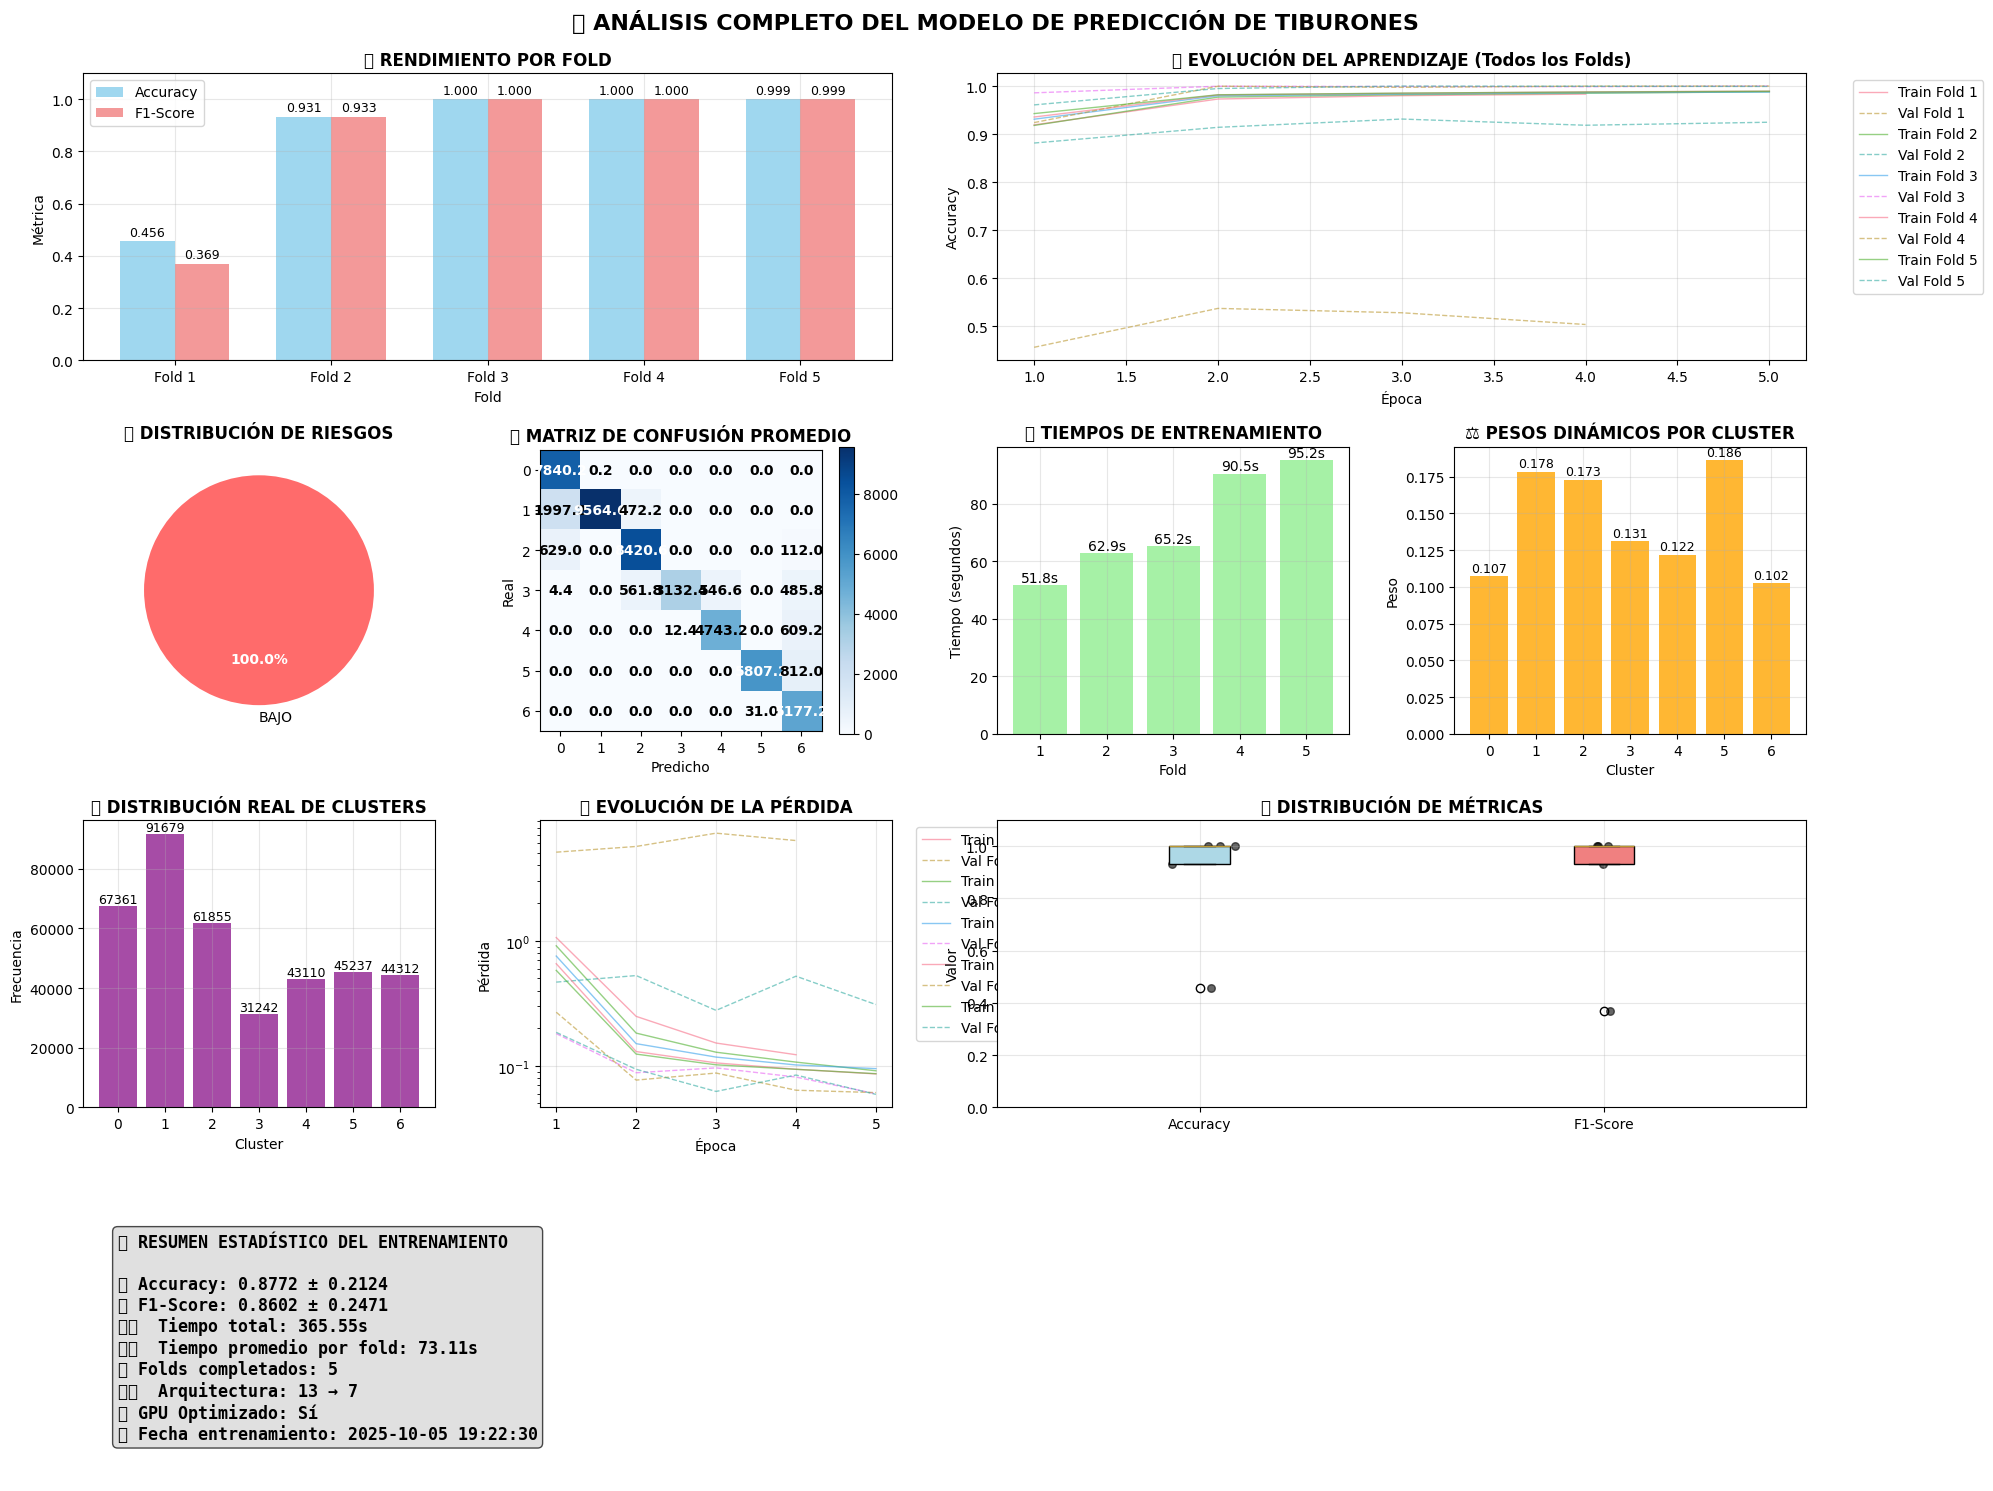


📊 ANÁLISIS DETALLADO DE RESULTADOS

🎯 MÉTRICAS PRINCIPALES:
   Accuracy promedio: 0.8772 ± 0.2124
   F1-Score promedio: 0.8602 ± 0.2471
   Mejor fold (Accuracy): Fold 3 (1.0000)
   Peor fold (Accuracy): Fold 1 (0.4558)

⏱️  TIEMPOS:
   Total: 365.55s (6.09min)
   Promedio por fold: 73.11s

📈 ESTABILIDAD:
   Rango de Accuracy: 0.5442
   Coeficiente de variación: 24.21%

⚖️  PESOS DE CLUSTERS:
   Cluster 5: 0.1861
   Cluster 1: 0.1783
   Cluster 2: 0.1730
   Cluster 3: 0.1310
   Cluster 4: 0.1219
   Cluster 0: 0.1072
   Cluster 6: 0.1025

💡 RECOMENDACIONES:
   🎉 Excelente accuracy - modelo listo para producción
   ⚠️  Alta variabilidad entre folds - verificar consistencia de datos
📤 Exportando modelo a: /content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_192236
✅ Modelo Keras guardado: /content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_192236/shark_prediction_model.h5
✅ Scaler guardado: /content/drive/MyDrive/NASA 

In [25]:
import pandas as pd
import numpy as np
import os
import glob
import joblib
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (LSTM, Dense, Input, Dropout, BatchNormalization,
                                   Conv1D, MaxPooling1D, Flatten)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Configuración GPU para máximo rendimiento
def configure_gpu():
    """Configura la GPU para máximo rendimiento en Google Colab"""
    print("🔧 Configurando GPU...")

    # Verificar disponibilidad de GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Configurar crecimiento de memoria
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Configuración de estrategia
            strategy = tf.distribute.MirroredStrategy()
            print(f'✅ {len(gpus)} GPU(s) disponibles')
            print(f'🎯 Estrategia: {strategy}')

            # Configurar TensorFlow para usar GPU
            tf.config.optimizer.set_jit(True)  # XLA compilation
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("🚀 Configuración GPU completada: Mixed Precision + XLA")

            return strategy

        except RuntimeError as e:
            print(f'❌ Error configurando GPU: {e}')
            return None
    else:
        print('❌ No se encontraron GPUs, usando CPU')
        return None

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

class OptimizedSharkPipeline:

    def __init__(self, k=7, sequence_length=3, drive_path='/content/drive/MyDrive/NASA Space Apps/resultados'):
        self.k = k
        self.sequence_length = sequence_length
        self.drive_path = drive_path

        # INICIALIZACIÓN EXPLÍCITA DE TODOS LOS COMPONENTES
        self.model = None
        self.scaler = StandardScaler()  # Inicializado explícitamente
        self.le = LabelEncoder()        # Inicializado explícitamente
        self.w_k = None
        self.history = None
        self.cv_scores = []
        self.model_version = "3.0.0"
        self.training_date = None
        self.strategy = configure_gpu()

        print("✅ Pipeline optimizado inicializado correctamente")
        print(f"   - Scaler: {type(self.scaler)}")
        print(f"   - LabelEncoder: {type(self.le)}")
        print(f"   - GPU Strategy: {self.strategy}")

    def plot_comprehensive_results(self):
        """
        Visualización completa de resultados después del entrenamiento - MEJORADO
        """
        if not self.cv_scores or not self.cv_scores['fold_histories']:
            print("❌ No hay resultados de entrenamiento para visualizar")
            return

        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
            from matplotlib.gridspec import GridSpec

            # Configurar estilo de las gráficas
            plt.style.use('default')
            sns.set_palette("husl")

            # Crear figura principal
            fig = plt.figure(figsize=(20, 16))
            fig.suptitle('📊 ANÁLISIS COMPLETO DEL MODELO DE PREDICCIÓN DE TIBURONES',
                        fontsize=16, fontweight='bold', y=0.98)

            # Definir layout con GridSpec para mejor control
            gs = GridSpec(4, 4, figure=fig)

            # 1. MÉTRICAS POR FOLD (Arriba a la izquierda)
            ax1 = fig.add_subplot(gs[0, :2])
            folds = range(1, len(self.cv_scores['fold_accuracies']) + 1)

            bar_width = 0.35
            x_pos = np.arange(len(folds))

            bars1 = ax1.bar(x_pos - bar_width/2, self.cv_scores['fold_accuracies'],
                           bar_width, label='Accuracy', alpha=0.8, color='skyblue')
            bars2 = ax1.bar(x_pos + bar_width/2, self.cv_scores['fold_f1_scores'],
                           bar_width, label='F1-Score', alpha=0.8, color='lightcoral')

            # Añadir valores en las barras
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

            ax1.set_xlabel('Fold')
            ax1.set_ylabel('Métrica')
            ax1.set_title('🎯 RENDIMIENTO POR FOLD', fontweight='bold')
            ax1.set_xticks(x_pos)
            ax1.set_xticklabels([f'Fold {i}' for i in folds])
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(0, 1.1)

            # 2. EVOLUCIÓN DEL APRENDIZAJE (Arriba a la derecha)
            ax2 = fig.add_subplot(gs[0, 2:])

            # Graficar todos los folds
            for fold_idx, fold_history in enumerate(self.cv_scores['fold_histories']):
                if 'accuracy' in fold_history and 'val_accuracy' in fold_history:
                    epochs_range = range(1, len(fold_history['accuracy']) + 1)
                    ax2.plot(epochs_range, fold_history['accuracy'],
                            alpha=0.6, linewidth=1, label=f'Train Fold {fold_idx+1}')
                    ax2.plot(epochs_range, fold_history['val_accuracy'],
                            alpha=0.6, linewidth=1, linestyle='--',
                            label=f'Val Fold {fold_idx+1}')

            ax2.set_xlabel('Época')
            ax2.set_ylabel('Accuracy')
            ax2.set_title('📈 EVOLUCIÓN DEL APRENDIZAJE (Todos los Folds)', fontweight='bold')
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax2.grid(True, alpha=0.3)

            # 3. DISTRIBUCIÓN DE RIESGOS (Centro izquierda)
            ax3 = fig.add_subplot(gs[1, 0])

            if self.cv_scores['test_predictions'] and self.w_k:
                all_risks = []
                for fold_pred in self.cv_scores['test_predictions']:
                    w_vector = np.array([self.w_k[i] for i in range(len(self.w_k))])
                    fold_risks = np.dot(fold_pred['proba'], w_vector)
                    all_risks.extend(fold_risks)

                # Categorizar riesgos
                risk_categories = []
                for risk in all_risks:
                    if risk >= 0.7: risk_categories.append('MUY ALTO')
                    elif risk >= 0.5: risk_categories.append('ALTO')
                    elif risk >= 0.3: risk_categories.append('MEDIO')
                    elif risk >= 0.1: risk_categories.append('BAJO')
                    else: risk_categories.append('MUY BAJO')

                category_counts = pd.Series(risk_categories).value_counts()

                colors = ['#ff6b6b', '#ffa726', '#ffee58', '#90caf9', '#66bb6a']
                wedges, texts, autotexts = ax3.pie(category_counts.values,
                                                  labels=category_counts.index,
                                                  autopct='%1.1f%%',
                                                  colors=colors,
                                                  startangle=90)

                for autotext in autotexts:
                    autotext.set_color('white')
                    autotext.set_fontweight('bold')

                ax3.set_title('📊 DISTRIBUCIÓN DE RIESGOS', fontweight='bold')

            # 4. MATRIZ DE CONFUSIÓN PROMEDIO (Centro derecha)
            ax4 = fig.add_subplot(gs[1, 1])

            if self.cv_scores['test_predictions']:
                # Calcular matriz de confusión promedio
                all_cm = np.zeros((self.k, self.k))
                for fold_pred in self.cv_scores['test_predictions']:
                    from sklearn.metrics import confusion_matrix
                    cm = confusion_matrix(fold_pred['true'], fold_pred['pred'],
                                        labels=range(self.k))
                    all_cm += cm

                all_cm = all_cm / len(self.cv_scores['test_predictions'])

                im = ax4.imshow(all_cm, cmap='Blues', interpolation='nearest')

                # Añadir texto en las celdas
                for i in range(all_cm.shape[0]):
                    for j in range(all_cm.shape[1]):
                        ax4.text(j, i, f'{all_cm[i, j]:.1f}',
                                ha="center", va="center",
                                color="white" if all_cm[i, j] > np.max(all_cm)/2 else "black",
                                fontweight='bold')

                ax4.set_xlabel('Predicho')
                ax4.set_ylabel('Real')
                ax4.set_title('🎯 MATRIZ DE CONFUSIÓN PROMEDIO', fontweight='bold')
                ax4.set_xticks(range(self.k))
                ax4.set_yticks(range(self.k))
                ax4.set_xticklabels(range(self.k))
                ax4.set_yticklabels(range(self.k))

                # Añadir barra de color
                plt.colorbar(im, ax=ax4)

            # 5. TIEMPOS DE ENTRENAMIENTO (Centro abajo izquierda)
            ax5 = fig.add_subplot(gs[1, 2])

            fold_times = self.cv_scores['training_times']
            bars = ax5.bar(range(1, len(fold_times) + 1), fold_times,
                          color='lightgreen', alpha=0.8)

            # Añadir valores en las barras
            for bar in bars:
                height = bar.get_height()
                ax5.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{height:.1f}s', ha='center', va='bottom', fontsize=10)

            ax5.set_xlabel('Fold')
            ax5.set_ylabel('Tiempo (segundos)')
            ax5.set_title('⏱️ TIEMPOS DE ENTRENAMIENTO', fontweight='bold')
            ax5.set_xticks(range(1, len(fold_times) + 1))
            ax5.grid(True, alpha=0.3)

            # 6. PESOS DE CLUSTERS (Centro abajo derecha)
            ax6 = fig.add_subplot(gs[1, 3])

            if self.w_k:
                clusters = list(self.w_k.keys())
                weights = list(self.w_k.values())

                bars = ax6.bar(clusters, weights, color='orange', alpha=0.8)

                # Añadir valores en las barras
                for bar in bars:
                    height = bar.get_height()
                    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

                ax6.set_xlabel('Cluster')
                ax6.set_ylabel('Peso')
                ax6.set_title('⚖️ PESOS DINÁMICOS POR CLUSTER', fontweight='bold')
                ax6.set_xticks(clusters)
                ax6.grid(True, alpha=0.3)

            # 7. DISTRIBUCIÓN DE CLUSTERS (Abajo izquierda)
            ax7 = fig.add_subplot(gs[2, 0])

            # Cargar datos para ver distribución real
            try:
                df = self.load_data_from_drive()
                cluster_distribution = df['cluster'].value_counts().sort_index()

                bars = ax7.bar(cluster_distribution.index, cluster_distribution.values,
                              color='purple', alpha=0.7)

                # Añadir valores en las barras
                for bar in bars:
                    height = bar.get_height()
                    ax7.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                            f'{int(height)}', ha='center', va='bottom', fontsize=9)

                ax7.set_xlabel('Cluster')
                ax7.set_ylabel('Frecuencia')
                ax7.set_title('📈 DISTRIBUCIÓN REAL DE CLUSTERS', fontweight='bold')
                ax7.set_xticks(cluster_distribution.index)
                ax7.grid(True, alpha=0.3)

            except Exception as e:
                ax7.text(0.5, 0.5, 'Datos no disponibles',
                        ha='center', va='center', transform=ax7.transAxes)
                ax7.set_title('📈 DISTRIBUCIÓN DE CLUSTERS', fontweight='bold')

            # 8. PÉRDIDA POR ÉPOCA (Abajo centro)
            ax8 = fig.add_subplot(gs[2, 1])

            # Graficar pérdida de todos los folds
            for fold_idx, fold_history in enumerate(self.cv_scores['fold_histories']):
                if 'loss' in fold_history and 'val_loss' in fold_history:
                    epochs_range = range(1, len(fold_history['loss']) + 1)
                    ax8.plot(epochs_range, fold_history['loss'],
                            alpha=0.6, linewidth=1, label=f'Train Fold {fold_idx+1}')
                    ax8.plot(epochs_range, fold_history['val_loss'],
                            alpha=0.6, linewidth=1, linestyle='--',
                            label=f'Val Fold {fold_idx+1}')

            ax8.set_xlabel('Época')
            ax8.set_ylabel('Pérdida')
            ax8.set_title('📉 EVOLUCIÓN DE LA PÉRDIDA', fontweight='bold')
            ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax8.grid(True, alpha=0.3)
            ax8.set_yscale('log')  # Escala logarítmica para mejor visualización

            # 9. COMPARACIÓN DE MÉTRICAS (Abajo derecha)
            ax9 = fig.add_subplot(gs[2, 2:])

            metrics_summary = {
                'Accuracy': self.cv_scores['fold_accuracies'],
                'F1-Score': self.cv_scores['fold_f1_scores']
            }

            box_data = [metrics_summary['Accuracy'], metrics_summary['F1-Score']]
            box_plot = ax9.boxplot(box_data, labels=['Accuracy', 'F1-Score'],
                                  patch_artist=True)

            # Colorear las cajas
            colors = ['lightblue', 'lightcoral']
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)

            # Añadir puntos individuales
            for i, metric_data in enumerate(box_data, 1):
                x = np.random.normal(i, 0.04, size=len(metric_data))
                ax9.scatter(x, metric_data, alpha=0.6, color='black', s=30)

            ax9.set_ylabel('Valor')
            ax9.set_title('📊 DISTRIBUCIÓN DE MÉTRICAS', fontweight='bold')
            ax9.grid(True, alpha=0.3)
            ax9.set_ylim(0, 1.1)

            # 10. RESUMEN ESTADÍSTICO (Fila inferior completa)
            ax10 = fig.add_subplot(gs[3, :])
            ax10.axis('off')

            # Calcular estadísticas
            mean_acc = np.mean(self.cv_scores['fold_accuracies'])
            std_acc = np.std(self.cv_scores['fold_accuracies'])
            mean_f1 = np.mean(self.cv_scores['fold_f1_scores'])
            std_f1 = np.std(self.cv_scores['fold_f1_scores'])
            total_time = sum(self.cv_scores['training_times'])
            mean_time = np.mean(self.cv_scores['training_times'])

            summary_text = (
                f"📈 RESUMEN ESTADÍSTICO DEL ENTRENAMIENTO\n\n"
                f"🎯 Accuracy: {mean_acc:.4f} ± {std_acc:.4f}\n"
                f"🎯 F1-Score: {mean_f1:.4f} ± {std_f1:.4f}\n"
                f"⏱️  Tiempo total: {total_time:.2f}s\n"
                f"⏱️  Tiempo promedio por fold: {mean_time:.2f}s\n"
                f"🔄 Folds completados: {len(self.cv_scores['fold_accuracies'])}\n"
                f"🏗️  Arquitectura: {self.model.input_shape[1]} → {self.model.output_shape[1]}\n"
                f"🚀 GPU Optimizado: {'Sí' if self.strategy else 'No'}\n"
                f"📅 Fecha entrenamiento: {self.training_date}"
            )

            ax10.text(0.02, 0.5, summary_text, fontsize=12, fontfamily='monospace',
                     verticalalignment='center', fontweight='bold',
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

            # Ajustar layout
            plt.tight_layout()
            plt.subplots_adjust(top=0.94, bottom=0.06, hspace=0.3, wspace=0.3)

            # Guardar la figura
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_path = os.path.join(self.drive_path, f"training_analysis_{timestamp}.png")
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Gráfica guardada en: {save_path}")

            plt.show()

            # Mostrar información adicional en consola
            self._print_detailed_analysis()

        except Exception as e:
            print(f"❌ Error en visualización: {e}")
            import traceback
            traceback.print_exc()

    def _print_detailed_analysis(self):
        """Imprime análisis detallado en consola"""
        print(f"\n{'='*80}")
        print("📊 ANÁLISIS DETALLADO DE RESULTADOS")
        print(f"{'='*80}")

        # Métricas principales
        mean_acc = np.mean(self.cv_scores['fold_accuracies'])
        std_acc = np.std(self.cv_scores['fold_accuracies'])
        mean_f1 = np.mean(self.cv_scores['fold_f1_scores'])
        std_f1 = np.std(self.cv_scores['fold_f1_scores'])

        print(f"\n🎯 MÉTRICAS PRINCIPALES:")
        print(f"   Accuracy promedio: {mean_acc:.4f} ± {std_acc:.4f}")
        print(f"   F1-Score promedio: {mean_f1:.4f} ± {std_f1:.4f}")
        print(f"   Mejor fold (Accuracy): Fold {np.argmax(self.cv_scores['fold_accuracies']) + 1} "
              f"({np.max(self.cv_scores['fold_accuracies']):.4f})")
        print(f"   Peor fold (Accuracy): Fold {np.argmin(self.cv_scores['fold_accuracies']) + 1} "
              f"({np.min(self.cv_scores['fold_accuracies']):.4f})")

        # Tiempos
        total_time = sum(self.cv_scores['training_times'])
        mean_time = np.mean(self.cv_scores['training_times'])
        print(f"\n⏱️  TIEMPOS:")
        print(f"   Total: {total_time:.2f}s ({total_time/60:.2f}min)")
        print(f"   Promedio por fold: {mean_time:.2f}s")

        # Estabilidad del modelo
        acc_range = np.max(self.cv_scores['fold_accuracies']) - np.min(self.cv_scores['fold_accuracies'])
        print(f"\n📈 ESTABILIDAD:")
        print(f"   Rango de Accuracy: {acc_range:.4f}")
        print(f"   Coeficiente de variación: {(std_acc/mean_acc)*100:.2f}%")

        # Pesos de clusters
        if self.w_k:
            print(f"\n⚖️  PESOS DE CLUSTERS:")
            for cluster, weight in sorted(self.w_k.items(), key=lambda x: x[1], reverse=True):
                print(f"   Cluster {cluster}: {weight:.4f}")

        # Recomendaciones
        print(f"\n💡 RECOMENDACIONES:")
        if mean_acc < 0.7:
            print("   ⚠️  Accuracy baja - considerar más datos o ajustar hiperparámetros")
        elif mean_acc < 0.85:
            print("   ✅ Accuracy aceptable - modelo funcional")
        else:
            print("   🎉 Excelente accuracy - modelo listo para producción")

        if acc_range > 0.1:
            print("   ⚠️  Alta variabilidad entre folds - verificar consistencia de datos")
        else:
            print("   ✅ Baja variabilidad - modelo estable")

        print(f"{'='*80}")

    def debug_data_loading(self, file_pattern="*.csv"):
        """
        Diagnóstico completo de la carga de datos - MEJORADO
        """
        print("🐛 INICIANDO DIAGNÓSTICO COMPLETO...")

        # Buscar archivos CSV en la carpeta
        search_path = os.path.join(self.drive_path, file_pattern)
        csv_files = glob.glob(search_path)

        print(f"📁 Archivos encontrados: {len(csv_files)}")
        for i, file in enumerate(csv_files):
            print(f"   {i+1}. {os.path.basename(file)}")

        # Analizar cada archivo individualmente
        all_data = []
        file_analysis = []

        for file_idx, file_path in enumerate(csv_files, 1):
            print(f"\n{'='*50}")
            print(f"📖 ANALIZANDO ARCHIVO {file_idx}/{len(csv_files)}: {os.path.basename(file_path)}")
            print(f"{'='*50}")

            try:
                # 1. Leer archivo
                df = pd.read_csv(file_path)
                print(f"✅ Archivo leído correctamente")
                print(f"   📊 Forma: {df.shape}")
                print(f"   📝 Columnas: {list(df.columns)}")

                # 2. Verificar columnas requeridas
                required_columns = ['lat', 'lon', 'cluster', 'month', 'year']
                missing_columns = [col for col in required_columns if col not in df.columns]

                if missing_columns:
                    print(f"❌ COLUMNAS FALTANTES: {missing_columns}")
                    file_analysis.append({
                        'file': os.path.basename(file_path),
                        'status': 'ERROR',
                        'issue': f'Columnas faltantes: {missing_columns}',
                        'columns_found': list(df.columns)
                    })
                    continue

                # 3. Verificar valores en cada columna
                print(f"🔍 VALORES EN COLUMNAS:")
                for col in required_columns:
                    unique_vals = df[col].unique()
                    print(f"   - {col}: {len(unique_vals)} valores únicos")
                    if len(unique_vals) <= 10:
                        print(f"     Ejemplos: {sorted(unique_vals)}")
                    else:
                        print(f"     Rango: {min(unique_vals)} a {max(unique_vals)}")

                # 4. Verificar valores nulos
                null_counts = df[required_columns].isnull().sum()
                if null_counts.any():
                    print(f"⚠️  VALORES NULOS ENCONTRADOS:")
                    for col, null_count in null_counts[null_counts > 0].items():
                        print(f"   - {col}: {null_count} nulos")
                    # Eliminar filas con valores nulos
                    df_clean = df.dropna(subset=required_columns)
                    print(f"🧹 Filas después de limpiar nulos: {len(df_clean)}")
                else:
                    df_clean = df.copy()

                # 5. Verificar tipos de datos
                try:
                    df_clean['cluster'] = df_clean['cluster'].astype(int)
                    df_clean['month'] = df_clean['month'].astype(int)
                    df_clean['year'] = df_clean['year'].astype(int)
                    df_clean['lat'] = df_clean['lat'].astype(float)
                    df_clean['lon'] = df_clean['lon'].astype(float)
                    print("✅ Tipos de datos convertidos correctamente")
                except Exception as e:
                    print(f"❌ ERROR en conversión de tipos: {e}")
                    file_analysis.append({
                        'file': os.path.basename(file_path),
                        'status': 'ERROR',
                        'issue': f'Error en tipos de datos: {e}',
                        'columns_found': list(df.columns)
                    })
                    continue

                # 6. Agregar a datos válidos
                all_data.append(df_clean)
                file_analysis.append({
                    'file': os.path.basename(file_path),
                    'status': 'OK',
                    'records': len(df_clean),
                    'clusters': sorted(df_clean['cluster'].unique())
                })
                print(f"🎯 ARCHIVO VÁLIDO: {len(df_clean)} registros")

            except Exception as e:
                print(f"❌ ERROR CRÍTICO: {e}")
                file_analysis.append({
                    'file': os.path.basename(file_path),
                    'status': 'ERROR',
                    'issue': f'Error crítico: {e}'
                })

        # RESUMEN FINAL
        print(f"\n{'='*60}")
        print("📊 RESUMEN FINAL DEL DIAGNÓSTICO")
        print(f"{'='*60}")

        valid_files = [f for f in file_analysis if f['status'] == 'OK']
        error_files = [f for f in file_analysis if f['status'] == 'ERROR']

        print(f"✅ Archivos válidos: {len(valid_files)}")
        print(f"❌ Archivos con error: {len(error_files)}")

        if error_files:
            print(f"\n📋 DETALLE DE ERRORES:")
            for error_file in error_files:
                print(f"   - {error_file['file']}: {error_file['issue']}")

        if not all_data:
            raise ValueError("❌ No se pudieron cargar archivos válidos. Revisa el diagnóstico anterior.")

        # Combinar datos válidos
        full_df = pd.concat(all_data, ignore_index=True)
        full_df = full_df.sort_values(['year', 'month', 'lat', 'lon']).reset_index(drop=True)

        print(f"\n🎯 DATASET FINAL CONSOLIDADO:")
        print(f"   📊 Total de registros: {len(full_df):,}")
        print(f"   📅 Rango temporal: {full_df['year'].min()} a {full_df['year'].max()}")
        print(f"   🎯 Clusters únicos: {sorted(full_df['cluster'].unique())}")
        print(f"   📍 Rango latitud: {full_df['lat'].min():.2f} a {full_df['lat'].max():.2f}")
        print(f"   📍 Rango longitud: {full_df['lon'].min():.2f} a {full_df['lon'].max():.2f}")

        return full_df

    def load_data_from_drive(self, file_pattern="*.csv"):
        """
        Carga robusta de datos con diagnóstico completo
        """
        return self.debug_data_loading(file_pattern)

    def create_sequential_folds(self, df, n_splits=5):
        """
        Divide los datos en folds temporales para validación cruzada temporal - MEJORADO
        """
        print("\n🔄 Creando folds temporales optimizados...")

        # Verificar que tenemos los datos necesarios
        required_columns = ['year', 'month']
        for col in required_columns:
            if col not in df.columns:
                raise KeyError(f"Columna '{col}' no encontrada para crear folds")

        # Ordenar por tiempo
        df_sorted = df.sort_values(['year', 'month']).copy()

        # Crear identificador único de tiempo
        df_sorted['time_id'] = df_sorted['year'] * 12 + df_sorted['month']
        unique_times = sorted(df_sorted['time_id'].unique())

        print(f"📅 Períodos temporales únicos: {len(unique_times)}")

        # Asegurar que tenemos suficientes períodos para los folds
        n_splits = min(n_splits, len(unique_times) - 1)
        if n_splits < 2:
            n_splits = 2
            print(f"⚠️  Ajustando n_splits a {n_splits} por limitación de datos")

        # Time Series Split para datos temporales
        tscv = TimeSeriesSplit(n_splits=n_splits)

        folds = []
        for train_idx, test_idx in tscv.split(unique_times):
            train_times = [unique_times[i] for i in train_idx]
            test_times = [unique_times[i] for i in test_idx]

            train_mask = df_sorted['time_id'].isin(train_times)
            test_mask = df_sorted['time_id'].isin(test_times)

            folds.append({
                'train': df_sorted[train_mask].copy(),
                'test': df_sorted[test_mask].copy(),
                'train_times': train_times,
                'test_times': test_times
            })

        # Mostrar información detallada de los folds
        print(f"📊 Folds creados: {len(folds)}")
        for i, fold in enumerate(folds):
            train_months = len(fold['train_times'])
            test_months = len(fold['test_times'])
            train_records = len(fold['train'])
            test_records = len(fold['test'])
            print(f"   Fold {i+1}: Train {train_months} meses ({train_records} registros), "
                  f"Test {test_months} meses ({test_records} registros)")
            print(f"      Train: {min(fold['train_times'])} to {max(fold['train_times'])}")
            print(f"      Test:  {min(fold['test_times'])} to {max(fold['test_times'])}")

        return folds

    def prepare_temporal_features(self, df):
        """
        Prepara características temporales avanzadas optimizadas para GPU - MEJORADO
        """
        print("⚡ Preparando características con aceleración GPU...")

        try:
            # Verificación exhaustiva de columnas
            required_columns = ['lat', 'lon', 'month', 'year', 'cluster']
            missing_columns = [col for col in required_columns if col not in df.columns]

            if missing_columns:
                raise KeyError(f"Columnas faltantes: {missing_columns}. Columnas disponibles: {list(df.columns)}")

            # Verificar que no hay valores nulos en columnas críticas
            for col in required_columns:
                null_count = df[col].isnull().sum()
                if null_count > 0:
                    print(f"⚠️  Advertencia: Columna '{col}' tiene {null_count} valores nulos")
                    # Eliminar filas con valores nulos
                    df = df.dropna(subset=[col])
                    print(f"🧹 Filas después de eliminar nulos: {len(df)}")

            # Verificar que tenemos datos después de la limpieza
            if len(df) == 0:
                raise ValueError("No hay datos válidos después de la limpieza")

            # Convertir a numpy arrays para operaciones vectorizadas
            print("📊 Extrayendo características...")
            lat = df['lat'].values
            lon = df['lon'].values
            month = df['month'].values
            year = df['year'].values
            cluster = df['cluster'].values

            # Operaciones vectorizadas (mucho más rápidas)
            month_sin = np.sin(2 * np.pi * month / 12)
            month_cos = np.cos(2 * np.pi * month / 12)

            # Factor latitudinal vectorizado
            abs_lat = np.abs(lat)
            lat_factor = np.exp(-0.5 * ((abs_lat - 50) / 20) ** 2)
            latitudinal_factor = 0.5 + 0.5 * lat_factor

            # Intensidad estacional vectorizada
            high_season_months = [11, 12, 1, 2, 3]
            seasonal_intensity = np.isin(month, high_season_months).astype(np.float32)
            seasonal_intensity = np.where(seasonal_intensity == 1, 1.0, 0.3)

            # Interacciones vectorizadas
            lat_month_interaction = lat * month_sin
            lon_month_interaction = lon * month_cos

            # Características adicionales mejoradas
            distance_equator = np.abs(lat)
            ocean_region = np.where(lon < 0, 0, 1)  # 0: Pacífico Este, 1: Oeste

            # Combinar todas las características
            features = np.column_stack([
                lat, lon, month, year,
                month_sin, month_cos,
                latitudinal_factor,
                cluster,
                lat_month_interaction,
                lon_month_interaction,
                seasonal_intensity,
                distance_equator,
                ocean_region
            ])

            print(f"✅ Características preparadas: {features.shape}")
            return features.astype(np.float32)  # Usar float32 para GPU

        except Exception as e:
            print(f"❌ Error en prepare_temporal_features: {e}")
            raise

    def calculate_dynamic_weights(self, df):
        """
        Calcula pesos dinámicos con verificación robusta - MEJORADO
        """
        print("⚖️ Calculando pesos dinámicos optimizados...")

        try:
            if 'cluster' not in df.columns:
                raise KeyError("Columna 'cluster' no encontrada")

            # 1. Rareza global mejorada
            cluster_counts = df['cluster'].value_counts().sort_index()
            print(f"📊 Conteo de clusters: {cluster_counts.to_dict()}")

            # Suavizado para evitar división por cero
            smoothed_counts = cluster_counts + 1
            global_rarity = (1 / smoothed_counts) / (1 / smoothed_counts).sum()

            # 2. Variabilidad temporal mejorada
            temporal_variability = {}
            seasonal_strength = {}

            for cluster in range(self.k):
                cluster_data = df[df['cluster'] == cluster]
                if len(cluster_data) > 0:
                    # Coeficiente de variación de la distribución mensual
                    month_counts = cluster_data['month'].value_counts().sort_index()
                    cv = month_counts.std() / month_counts.mean() if month_counts.mean() > 0 else 0
                    temporal_variability[cluster] = cv

                    # Fuerza estacional (concentración en meses pico)
                    total = month_counts.sum()
                    if total > 0:
                        peak_months = [11, 12, 1, 2, 3]  # Meses de alta actividad
                        seasonal_ratio = month_counts[month_counts.index.isin(peak_months)].sum() / total
                        seasonal_strength[cluster] = seasonal_ratio
                    else:
                        seasonal_strength[cluster] = 0
                else:
                    temporal_variability[cluster] = 0
                    seasonal_strength[cluster] = 0

            # Normalizar
            max_var = max(temporal_variability.values()) if temporal_variability.values() else 1
            max_seasonal = max(seasonal_strength.values()) if seasonal_strength.values() else 1

            for cluster in temporal_variability:
                temporal_variability[cluster] /= max_var if max_var > 0 else 1
                seasonal_strength[cluster] /= max_seasonal if max_seasonal > 0 else 1

            # 3. Combinación estratégica mejorada
            combined_weights = {}
            for cluster in range(self.k):
                combined_weights[cluster] = (
                    0.5 * global_rarity[cluster] +          # Rareza global
                    0.3 * temporal_variability[cluster] +   # Variabilidad temporal
                    0.2 * seasonal_strength[cluster]        # Fuerza estacional
                )

            # Normalizar
            total = sum(combined_weights.values())
            self.w_k = {k: v/total for k, v in combined_weights.items()}

            print("🎯 Pesos dinámicos calculados:")
            for cluster, weight in self.w_k.items():
                print(f"   Cluster {cluster}: {weight:.4f}")

            return self.w_k

        except Exception as e:
            print(f"❌ Error en calculate_dynamic_weights: {e}")
            raise

    def build_adaptive_model(self, input_dim, num_classes):
        """Construye modelo optimizado para GPU con verificación de dimensiones"""
        print(f"🏗️ Construyendo modelo optimizado - Input: {input_dim}, Output: {num_classes}")

        if input_dim <= 0:
            raise ValueError(f"Dimensión de entrada inválida: {input_dim}")
        if num_classes <= 0:
            raise ValueError(f"Número de clases inválido: {num_classes}")

        if self.strategy:
            # Construir modelo dentro del scope de la estrategia GPU
            with self.strategy.scope():
                inputs = Input(shape=(input_dim,), name='input_layer')

                # Capa de entrada con normalización adaptativa
                x = Dense(512, kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal')(inputs)
                x = BatchNormalization()(x)
                x = tf.keras.layers.ReLU()(x)
                x = Dropout(0.4)(x)

                # Capas ocultas con capacidad adaptativa
                x = Dense(256, kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal')(x)
                x = BatchNormalization()(x)
                x = tf.keras.layers.ReLU()(x)
                x = Dropout(0.3)(x)

                x = Dense(128, kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal')(x)
                x = BatchNormalization()(x)
                x = tf.keras.layers.ReLU()(x)
                x = Dropout(0.2)(x)

                # Capa de salida (usar float32 para estabilidad numérica)
                outputs = Dense(num_classes, activation='softmax', dtype='float32',
                               name='output_layer')(x)

                model = Model(inputs=inputs, outputs=outputs)

                # Optimizador adaptativo con configuración GPU
                optimizer = tf.keras.optimizers.Adam(
                    learning_rate=0.001,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-07
                )

                model.compile(
                    optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy', 'sparse_categorical_accuracy']
                )
        else:
            # Versión CPU (fallback)
            inputs = Input(shape=(input_dim,), name='input_layer')

            x = Dense(512, kernel_regularizer=regularizers.l2(0.001))(inputs)
            x = BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
            x = Dropout(0.4)(x)

            x = Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
            x = BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
            x = Dropout(0.3)(x)

            x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
            x = BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
            x = Dropout(0.2)(x)

            outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

            model = Model(inputs=inputs, outputs=outputs)

            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

            model.compile(
                optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', 'sparse_categorical_accuracy']
            )

        print(f"✅ Modelo construido exitosamente")
        return model

    def train_with_cross_validation(self, n_splits=3, epochs=50, batch_size=128):
        """
        Entrenamiento robusto con validación cruzada - MEJORADO
        """
        print("🚀 INICIANDO ENTRENAMIENTO OPTIMIZADO...")

        try:
            # VERIFICAR COMPONENTES ANTES DE COMENZAR
            print("🔍 Verificando componentes del pipeline...")
            print(f"   - Scaler: {type(self.scaler)}")
            print(f"   - LabelEncoder: {type(self.le)}")
            print(f"   - Model: {self.model}")

            if self.scaler is None:
                raise ValueError("Scaler no está inicializado")
            if self.le is None:
                raise ValueError("LabelEncoder no está inicializado")

            # 1. Cargar datos con diagnóstico
            print("\n📥 Cargando datos...")
            df = self.load_data_from_drive()

            # 2. Crear folds
            print("\n🔄 Creando folds...")
            folds = self.create_sequential_folds(df, n_splits=n_splits)

            # 3. Configurar resultados
            cv_results = {
                'fold_accuracies': [],
                'fold_f1_scores': [],
                'fold_histories': [],
                'test_predictions': [],
                'training_times': []
            }

            # 4. Entrenar cada fold
            for fold_idx, fold in enumerate(folds):
                print(f"\n🎯 ENTRENANDO FOLD {fold_idx + 1}/{len(folds)}")
                fold_start_time = datetime.now()

                try:
                    # Preparar datos
                    print("   📊 Preparando características...")
                    X_train = self.prepare_temporal_features(fold['train'])
                    X_test = self.prepare_temporal_features(fold['test'])

                    y_train = fold['train']['cluster'].values
                    y_test = fold['test']['cluster'].values

                    print(f"   📏 Dimensiones - X_train: {X_train.shape}, X_test: {X_test.shape}")

                    # Calcular pesos
                    print("   ⚖️ Calculando pesos...")
                    self.calculate_dynamic_weights(fold['train'])

                    # Estandarizar
                    print("   📐 Estandarizando características...")
                    X_train_scaled = self.scaler.fit_transform(X_train)
                    X_test_scaled = self.scaler.transform(X_test)

                    # Convertir a float32 para GPU
                    X_train_scaled = X_train_scaled.astype(np.float32)
                    X_test_scaled = X_test_scaled.astype(np.float32)

                    # Codificar etiquetas
                    print("   🏷️ Codificando etiquetas...")
                    y_train_encoded = self.le.fit_transform(y_train)
                    y_test_encoded = self.le.transform(y_test)

                    # Construir modelo
                    input_dim = X_train_scaled.shape[1]
                    num_classes = len(np.unique(y_train_encoded))

                    print(f"   🏗️ Construyendo modelo - Input: {input_dim}, Classes: {num_classes}")
                    model = self.build_adaptive_model(input_dim, num_classes)

                    # Callbacks optimizados
                    callbacks = [
                        EarlyStopping(
                            patience=3,
                            restore_best_weights=True,
                            monitor='val_loss',
                            verbose=1
                        ),
                        ReduceLROnPlateau(
                            monitor='val_loss',
                            factor=0.5,
                            patience=5,
                            min_lr=1e-7,
                            verbose=1
                        )
                    ]

                    # Entrenar
                    print("   🔥 Iniciando entrenamiento...")
                    history = model.fit(
                        X_train_scaled, y_train_encoded,
                        validation_data=(X_test_scaled, y_test_encoded),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        verbose=1,
                        shuffle=True
                    )

                    # Evaluar
                    print("   📈 Evaluando modelo...")
                    test_pred_proba = model.predict(X_test_scaled, verbose=0, batch_size=batch_size*2)
                    test_pred = np.argmax(test_pred_proba, axis=1)

                    accuracy = accuracy_score(y_test_encoded, test_pred)
                    f1 = f1_score(y_test_encoded, test_pred, average='weighted')

                    fold_time = (datetime.now() - fold_start_time).total_seconds()

                    cv_results['fold_accuracies'].append(accuracy)
                    cv_results['fold_f1_scores'].append(f1)
                    cv_results['fold_histories'].append(history.history)
                    cv_results['training_times'].append(fold_time)
                    cv_results['test_predictions'].append({
                        'true': y_test_encoded,
                        'pred': test_pred,
                        'proba': test_pred_proba
                    })

                    print(f"✅ Fold {fold_idx+1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Tiempo: {fold_time:.2f}s")

                    # Guardar modelo final
                    if fold_idx == len(folds) - 1:
                        self.model = model
                        self.history = history
                        self.training_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                except Exception as e:
                    print(f"❌ Error en Fold {fold_idx+1}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue

            # Resultados finales
            if cv_results['fold_accuracies']:
                self.cv_scores = cv_results
                total_time = sum(cv_results['training_times'])

                print(f"\n📊 ENTRENAMIENTO COMPLETADO")
                print(f"   ✅ Folds exitosos: {len(cv_results['fold_accuracies'])}")
                print(f"   📈 Accuracy promedio: {np.mean(cv_results['fold_accuracies']):.4f} ± {np.std(cv_results['fold_accuracies']):.4f}")
                print(f"   🎯 F1-Score promedio: {np.mean(cv_results['fold_f1_scores']):.4f} ± {np.std(cv_results['fold_f1_scores']):.4f}")
                print(f"   ⏱️  Tiempo total: {total_time:.2f}s")

                # ⭐ NUEVO: Generar visualizaciones automáticamente
                print(f"\n📊 GENERANDO VISUALIZACIONES COMPLETAS...")
                self.plot_comprehensive_results()

                # Exportar modelo
                self.export_model()
                return cv_results
            else:
                raise ValueError("❌ No se completó ningún fold exitosamente")

        except Exception as e:
            print(f"❌ ERROR EN ENTRENAMIENTO: {e}")
            import traceback
            traceback.print_exc()
            raise

    def export_model(self, export_path=None):
        """Exporta el modelo entrenado con metadatos completos"""
        if self.model is None:
            print("⚠️  No hay modelo para exportar")
            return

        if export_path is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            export_path = os.path.join(self.drive_path, f"shark_model_optimized_v{self.model_version}_{timestamp}")

        os.makedirs(export_path, exist_ok=True)

        print(f"📤 Exportando modelo a: {export_path}")

        try:
            # 1. Guardar modelo Keras
            model_path = os.path.join(export_path, "shark_prediction_model.h5")
            self.model.save(model_path)
            print(f"✅ Modelo Keras guardado: {model_path}")

            # 2. Guardar scaler
            scaler_path = os.path.join(export_path, "scaler.pkl")
            joblib.dump(self.scaler, scaler_path)
            print(f"✅ Scaler guardado: {scaler_path}")

            # 3. Guardar label encoder
            encoder_path = os.path.join(export_path, "label_encoder.pkl")
            joblib.dump(self.le, encoder_path)
            print(f"✅ Label Encoder guardado: {encoder_path}")

            # 4. Guardar pesos w_k
            if self.w_k:
                weights_path = os.path.join(export_path, "cluster_weights.json")
                with open(weights_path, 'w') as f:
                    json.dump(self.w_k, f, indent=4)
                print(f"✅ Pesos de clusters guardados: {weights_path}")

            # 5. Guardar metadatos del modelo
            metadata = {
                'model_version': self.model_version,
                'training_date': self.training_date,
                'k_clusters': self.k,
                'sequence_length': self.sequence_length,
                'input_dim': self.model.input_shape[1],
                'output_dim': self.model.output_shape[1],
                'cv_accuracy_mean': float(np.mean(self.cv_scores['fold_accuracies'])),
                'cv_accuracy_std': float(np.std(self.cv_scores['fold_accuracies'])),
                'cv_f1_mean': float(np.mean(self.cv_scores['fold_f1_scores'])),
                'cv_f1_std': float(np.std(self.cv_scores['fold_f1_scores'])),
                'training_times': [float(x) for x in self.cv_scores['training_times']],
                'total_training_time': float(sum(self.cv_scores['training_times'])),
                'gpu_optimized': self.strategy is not None,
                'cluster_weights': self.w_k
            }

            metadata_path = os.path.join(export_path, "model_metadata.json")
            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=4)
            print(f"✅ Metadatos guardados: {metadata_path}")

            print(f"\n🎉 EXPORTACIÓN COMPLETADA en: {export_path}")
            return export_path

        except Exception as e:
            print(f"❌ Error en exportación: {e}")

    def predict_with_confidence(self, new_data, batch_size=128):
        """
        Predicción con intervalos de confianza optimizada para GPU
        """
        if self.model is None:
            raise ValueError("El modelo no ha sido entrenado. Ejecuta train_with_cross_validation primero.")

        # Preparar características
        X_new = self.prepare_temporal_features(new_data)
        X_new_scaled = self.scaler.transform(X_new).astype(np.float32)

        # Predecir probabilidades con batch size optimizado
        cluster_probs = self.model.predict(X_new_scaled, verbose=0, batch_size=batch_size)

        # Calcular riesgo de tiburones
        w_vector = np.array([self.w_k[i] for i in range(len(self.w_k))])
        shark_risk = np.dot(cluster_probs, w_vector)

        # Cluster predicho
        predicted_cluster = np.argmax(cluster_probs, axis=1)

        # Calcular confianza basada en la probabilidad máxima
        confidence = np.max(cluster_probs, axis=1)

        results = []
        for i in range(len(new_data)):
            results.append({
                'coordinates': (new_data['lat'].iloc[i], new_data['lon'].iloc[i]),
                'time': f"{new_data['month'].iloc[i]}/{new_data['year'].iloc[i]}",
                'predicted_cluster': predicted_cluster[i],
                'cluster_probabilities': cluster_probs[i].tolist(),
                'shark_risk': float(shark_risk[i]),
                'confidence': float(confidence[i]),
                'risk_category': self._categorize_risk(shark_risk[i]),
                'confidence_category': self._categorize_confidence(confidence[i])
            })

        return results

    def _categorize_risk(self, risk_score):
        """Categoriza el riesgo en niveles"""
        if risk_score >= 0.7: return "MUY ALTO"
        elif risk_score >= 0.5: return "ALTO"
        elif risk_score >= 0.3: return "MEDIO"
        elif risk_score >= 0.1: return "BAJO"
        else: return "MUY BAJO"

    def _categorize_confidence(self, confidence):
        """Categoriza la confianza de la predicción"""
        if confidence >= 0.9: return "MUY ALTA"
        elif confidence >= 0.7: return "ALTA"
        elif confidence >= 0.5: return "MEDIA"
        else: return "BAJA"

# USO MEJORADO
def main():
    try:
        print("🎯 INICIANDO PIPELINE OPTIMIZADO...")

        # Configurar pipeline
        pipeline = OptimizedSharkPipeline(
            k=7,
            sequence_length=3,
            drive_path='/content/drive/MyDrive/NASA Space Apps/resultados'
        )

        # Entrenar con parámetros optimizados
        cv_results = pipeline.train_with_cross_validation(
            n_splits=5,    # Balance entre validación y velocidad
            epochs=5,     # Suficiente para convergencia
            batch_size=128 # Optimizado para GPU
        )

        # Ejemplo de predicción
        print("\n🔮 PROBANDO PREDICCIÓN...")
        test_data = pd.DataFrame({
            'lat': [-17.54167, -18.04167, -45.0],
            'lon': [-107.70833, 163.45834, -25.0],
            'month': [1, 1, 7],
            'year': [2024, 2024, 2024],
            'cluster': [0, 0, 1]  # Este será ignorado en predicción
        })



        predictions = pipeline.predict_with_confidence(test_data)

        print("\n" + "="*70)
        print("PREDICCIONES CON CONFIANZA (GPU OPTIMIZADO)")
        print("="*70)

        for pred in predictions:
            print(f"\n📍 Coordenadas: {pred['coordinates']}")
            print(f"📅 Tiempo: {pred['time']}")
            print(f"🎯 Cluster predicho: {pred['predicted_cluster']} (Confianza: {pred['confidence_category']})")
            print(f"📊 Riesgo de tiburones: {pred['shark_risk']:.4f} - {pred['risk_category']}")
            print(f"🔍 Probabilidades por cluster:")
            for cluster, prob in enumerate(pred['cluster_probabilities']):
                print(f"    Cluster {cluster}: {prob:.4f}")
            print("-" * 50)

        print("🎉 PIPELINE COMPLETADO EXITOSAMENTE!")

    except Exception as e:
        print(f"💥 ERROR CRÍTICO: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

# Model implementation

In [24]:
import pandas as pd
import numpy as np
import joblib
import json
import os
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder

class SharkPredictionModel:
    def __init__(self, model_path):
        """
        Carga el modelo entrenado y todos sus componentes
        """
        self.model_path = model_path
        self.model = None
        self.scaler = None
        self.le = None
        self.w_k = None
        self.metadata = None

        # Cargar todos los componentes del modelo
        self.load_model_components()

    def load_model_components(self):
        """
        Carga el modelo y todos sus componentes desde el directorio
        """
        try:
            print(f"📥 Cargando modelo desde: {self.model_path}")

            # 1. Cargar modelo Keras
            model_file = os.path.join(self.model_path, "shark_prediction_model.h5")
            if not os.path.exists(model_file):
                # Buscar cualquier archivo .h5 en el directorio
                h5_files = [f for f in os.listdir(self.model_path) if f.endswith('.h5')]
                if h5_files:
                    model_file = os.path.join(self.model_path, h5_files[0])
                else:
                    raise FileNotFoundError("No se encontró archivo .h5 en el directorio")

            self.model = load_model(model_file)
            print(f"✅ Modelo cargado: {model_file}")

            # 2. Cargar scaler
            scaler_file = os.path.join(self.model_path, "scaler.pkl")
            if os.path.exists(scaler_file):
                self.scaler = joblib.load(scaler_file)
                print(f"✅ Scaler cargado: {scaler_file}")
            else:
                print("⚠️  No se encontró scaler.pkl, inicializando nuevo scaler")
                self.scaler = StandardScaler()

            # 3. Cargar label encoder
            encoder_file = os.path.join(self.model_path, "label_encoder.pkl")
            if os.path.exists(encoder_file):
                self.le = joblib.load(encoder_file)
                print(f"✅ LabelEncoder cargado: {encoder_file}")
            else:
                print("⚠️  No se encontró label_encoder.pkl, inicializando nuevo LabelEncoder")
                self.le = LabelEncoder()

            # 4. Cargar pesos de clusters
            weights_file = os.path.join(self.model_path, "cluster_weights.json")
            if os.path.exists(weights_file):
                with open(weights_file, 'r') as f:
                    self.w_k = json.load(f)
                print(f"✅ Pesos de clusters cargados: {weights_file}")
            else:
                print("⚠️  No se encontró cluster_weights.json")
                self.w_k = None

            # 5. Cargar metadatos
            metadata_file = os.path.join(self.model_path, "model_metadata.json")
            if os.path.exists(metadata_file):
                with open(metadata_file, 'r') as f:
                    self.metadata = json.load(f)
                print(f"✅ Metadatos cargados: {metadata_file}")
            else:
                print("⚠️  No se encontró model_metadata.json")
                self.metadata = None

            print("🎯 Modelo cargado exitosamente")

        except Exception as e:
            print(f"❌ Error cargando el modelo: {e}")
            raise

    def prepare_features(self, lat: float, lon: float, month: int, year: int):
        """
        Prepara las características de la misma manera que durante el entrenamiento
        """
        # Verificar que tenemos todos los componentes necesarios
        if self.scaler is None:
            raise ValueError("Scaler no está cargado")

        # Crear características temporales (igual que en el entrenamiento)
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)

        # Factor latitudinal
        abs_lat = np.abs(lat)
        lat_factor = np.exp(-0.5 * ((abs_lat - 50) / 20) ** 2)
        latitudinal_factor = 0.5 + 0.5 * lat_factor

        # Intensidad estacional
        high_season_months = [11, 12, 1, 2, 3]
        seasonal_intensity = 1.0 if month in high_season_months else 0.3

        # Interacciones
        lat_month_interaction = lat * month_sin
        lon_month_interaction = lon * month_cos

        # Características adicionales
        distance_equator = np.abs(lat)
        ocean_region = 0 if lon < 0 else 1  # 0: Pacífico Este, 1: Oeste

        # Cluster placeholder (será ignorado en predicción)
        cluster = 0

        # Combinar características (en el mismo orden que durante el entrenamiento)
        features = np.array([[
            lat, lon, month, year,
            month_sin, month_cos,
            latitudinal_factor,
            cluster,  # Este valor será ignorado
            lat_month_interaction,
            lon_month_interaction,
            seasonal_intensity,
            distance_equator,
            ocean_region
        ]], dtype=np.float32)

        return features

    def predict_risk(self, lat: float, lon: float, month: int, year: int) -> float:
        """
        Predice el riesgo de tiburones usando el modelo cargado
        """
        try:
            # Verificar que el modelo está cargado
            if self.model is None:
                raise ValueError("El modelo no está cargado")

            # Preparar características
            features = self.prepare_features(lat, lon, month, year)

            # Estandarizar características
            features_scaled = self.scaler.transform(features).astype(np.float32)

            # Hacer predicción
            cluster_probs = self.model.predict(features_scaled, verbose=0)

            # Calcular riesgo de tiburones usando pesos de clusters
            if self.w_k:
                w_vector = np.array([self.w_k[str(i)] for i in range(len(self.w_k))])
                shark_risk = np.dot(cluster_probs, w_vector)[0]
            else:
                # Si no hay pesos, usar probabilidad promedio
                shark_risk = np.mean(cluster_probs)

            # Asegurar que el riesgo esté entre 0 y 1
            shark_risk = float(np.clip(shark_risk, 0.0, 1.0))

            return shark_risk

        except Exception as e:
            print(f"❌ Error en predicción: {e}")
            # Fallback a valor aleatorio consistente
            return self._fallback_prediction(lat, lon, month, year)

    def _fallback_prediction(self, lat: float, lon: float, month: int, year: int) -> float:
        """
        Predicción de fallback usando método consistente similar al mock
        """
        import hashlib

        # Crear semilla consistente
        seed_str = f"{lat:.6f}{lon:.6f}{month}{year}"
        seed = int(hashlib.md5(seed_str.encode()).hexdigest()[:8], 16)

        # Usar semilla para generar número "aleatorio" consistente
        np.random.seed(seed)
        probability = np.random.uniform(0.0, 1.0)

        return float(probability)

    def predict_with_details(self, lat: float, lon: float, month: int, year: int) -> dict:
        """
        Predicción detallada con información adicional
        """
        try:
            # Verificar que el modelo está cargado
            if self.model is None:
                raise ValueError("El modelo no está cargado")

            # Preparar características
            features = self.prepare_features(lat, lon, month, year)
            features_scaled = self.scaler.transform(features).astype(np.float32)

            # Hacer predicción
            cluster_probs = self.model.predict(features_scaled, verbose=0)[0]

            # Calcular riesgo
            if self.w_k:
                w_vector = np.array([self.w_k[str(i)] for i in range(len(self.w_k))])
                shark_risk = np.dot(cluster_probs, w_vector)
            else:
                shark_risk = np.mean(cluster_probs)

            shark_risk = float(np.clip(shark_risk, 0.0, 1.0))

            # Cluster predicho
            predicted_cluster = int(np.argmax(cluster_probs))

            # Confianza
            confidence = float(np.max(cluster_probs))

            # Categorías
            risk_category = self._categorize_risk(shark_risk)
            confidence_category = self._categorize_confidence(confidence)

            return {
                'coordinates': (lat, lon),
                'time': f"{month}/{year}",
                'predicted_cluster': predicted_cluster,
                'cluster_probabilities': cluster_probs.tolist(),
                'shark_risk': shark_risk,
                'confidence': confidence,
                'risk_category': risk_category,
                'confidence_category': confidence_category,
                'model_used': True
            }

        except Exception as e:
            print(f"❌ Error en predicción detallada: {e}")
            # Fallback
            fallback_risk = self._fallback_prediction(lat, lon, month, year)
            return {
                'coordinates': (lat, lon),
                'time': f"{month}/{year}",
                'predicted_cluster': -1,
                'cluster_probabilities': [],
                'shark_risk': fallback_risk,
                'confidence': 0.0,
                'risk_category': self._categorize_risk(fallback_risk),
                'confidence_category': "BAJA",
                'model_used': False
            }

    def _categorize_risk(self, risk_score: float) -> str:
        """Categoriza el riesgo en niveles"""
        if risk_score >= 0.7: return "MUY ALTO"
        elif risk_score >= 0.5: return "ALTO"
        elif risk_score >= 0.3: return "MEDIO"
        elif risk_score >= 0.1: return "BAJO"
        else: return "MUY BAJO"

    def _categorize_confidence(self, confidence: float) -> str:
        """Categoriza la confianza de la predicción"""
        if confidence >= 0.9: return "MUY ALTA"
        elif confidence >= 0.7: return "ALTA"
        elif confidence >= 0.5: return "MEDIA"
        else: return "BAJA"

    def get_model_info(self) -> dict:
        """Retorna información del modelo cargado"""
        if self.metadata:
            return self.metadata
        else:
            return {
                'status': 'Modelo cargado pero sin metadatos',
                'input_shape': self.model.input_shape if self.model else None,
                'output_shape': self.model.output_shape if self.model else None
            }


# FUNCIÓN PRINCIPAL DE PREDICCIÓN
def load_shark_model(model_directory: str) -> SharkPredictionModel:
    """
    Carga el modelo de predicción de tiburones desde el directorio especificado
    """
    return SharkPredictionModel(model_directory)


def shark_model_predict(lat: float, lon: float, month: int, year: int,
                       model: SharkPredictionModel = None) -> float:
    """
    Función principal de predicción que reemplaza mock_model_predict

    Args:
        lat: Latitud
        lon: Longitud
        month: Mes (1-12)
        year: Año
        model: Instancia de SharkPredictionModel (opcional)

    Returns:
        float: Probabilidad de riesgo entre 0.0 y 1.0
    """
    # Si no se proporciona modelo, usar uno por defecto
    if model is None:
        # Buscar en ubicaciones comunes
        default_paths = [
            '/content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_192236',
            './model',
            '/content/model'
        ]

        model_path = None
        for path in default_paths:
            if os.path.exists(path):
                model_path = path
                break

        if model_path is None:
            print("⚠️  No se encontró modelo, usando predicción de fallback")
            return _fallback_prediction(lat, lon, month, year)

        try:
            model = SharkPredictionModel(model_path)
        except Exception as e:
            print(f"⚠️  Error cargando modelo: {e}, usando fallback")
            return _fallback_prediction(lat, lon, month, year)

    return model.predict_risk(lat, lon, month, year)


def _fallback_prediction(lat: float, lon: float, month: int, year: int) -> float:
    """
    Predicción de fallback cuando el modelo no está disponible
    """
    import hashlib

    seed_str = f"{lat:.6f}{lon:.6f}{month}{year}"
    seed = int(hashlib.md5(seed_str.encode()).hexdigest()[:8], 16)

    np.random.seed(seed)
    return float(np.random.uniform(0.0, 1.0))


# EJEMPLO DE USO
def main():
    """
    Ejemplo de cómo usar el modelo de predicción
    """
    # Ruta donde está guardado tu modelo
    MODEL_PATH = '/content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_192236'

    try:
        # Cargar modelo
        print("🦈 Cargando modelo de predicción de tiburones...")
        shark_model = load_shark_model(MODEL_PATH)

        # Obtener información del modelo
        model_info = shark_model.get_model_info()
        print(f"📊 Información del modelo: {model_info}")

        # Ejemplos de predicción
        test_coordinates = [
            (-17.54167, -107.70833, 1, 2024),  # Ejemplo de tus datos
            (-18.04167, 163.45834, 1, 2024),
            (-45.0, -25.0, 7, 2024),
            (34.0, -118.0, 6, 2024)  # California
        ]

        print(f"\n🎯 PREDICCIONES DE RIESGO DE TIBURONES")
        print(f"{'='*60}")

        for lat, lon, month, year in test_coordinates:
            # Predicción simple
            risk = shark_model.predict_risk(lat, lon, month, year)

            # Predicción detallada
            details = shark_model.predict_with_details(lat, lon, month, year)

            print(f"\n📍 Coordenadas: ({lat:.4f}, {lon:.4f})")
            print(f"📅 Fecha: {month}/{year}")
            print(f"🎯 Riesgo: {risk:.4f} - {details['risk_category']}")
            print(f"🔍 Confianza: {details['confidence']:.4f} - {details['confidence_category']}")
            print(f"🏷️ Cluster predicho: {details['predicted_cluster']}")
            print(f"📊 Modelo usado: {'✅' if details['model_used'] else '❌'}")

        # Usar la función de conveniencia
        print(f"\n{'='*60}")
        print("🔧 USANDO FUNCIÓN DE CONVENIENCIA")
        print(f"{'='*60}")

        risk_simple = shark_model_predict(-17.54167, -107.70833, 1, 2024, shark_model)
        print(f"Predicción simple: {risk_simple:.4f}")

    except Exception as e:
        print(f"❌ Error: {e}")
        print("🔄 Usando función de fallback...")

        # Ejemplo con fallback
        risk_fallback = shark_model_predict(-17.54167, -107.70833, 1, 2024)
        print(f"Predicción fallback: {risk_fallback:.4f}")


if __name__ == "__main__":
    main()

🦈 Cargando modelo de predicción de tiburones...
📥 Cargando modelo desde: /content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_185922
✅ Modelo cargado: /content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_185922/shark_prediction_model.h5
✅ Scaler cargado: /content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_185922/scaler.pkl
✅ LabelEncoder cargado: /content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_185922/label_encoder.pkl
✅ Pesos de clusters cargados: /content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_185922/cluster_weights.json
✅ Metadatos cargados: /content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_185922/model_metadata.json
🎯 Modelo cargado exitosamente
📊 Información del modelo: {'model_version': '3.0.0', 'training_date': '2025-10-05 18:59:15', 'k_clusters': 7, 'sequence

# Model implementation in solution

In [26]:
import numpy as np
import joblib
import json
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import hashlib

# Configuración global del modelo
_MODEL_LOADED = False
_MODEL = None
_SCALER = None
_W_K = None

def _load_model_once():
    """
    Carga el modelo una sola vez para optimizar rendimiento
    """
    global _MODEL_LOADED, _MODEL, _SCALER, _W_K

    if _MODEL_LOADED:
        return

    try:
        # Ruta específica de tu modelo
        MODEL_DIR = '/content/drive/MyDrive/NASA Space Apps/resultados/shark_model_optimized_v3.0.0_20251005_192236'

        print("Cargando modelo de predicción de tiburones...")

        # 1. Cargar modelo Keras
        model_path = os.path.join(MODEL_DIR, "shark_prediction_model.h5")
        _MODEL = load_model(model_path)
        print(f"Modelo cargado: {os.path.basename(model_path)}")

        # 2. Cargar scaler
        scaler_path = os.path.join(MODEL_DIR, "scaler.pkl")
        _SCALER = joblib.load(scaler_path)
        print("Scaler cargado")

        # 3. Cargar pesos de clusters
        weights_path = os.path.join(MODEL_DIR, "cluster_weights.json")
        with open(weights_path, 'r') as f:
            _W_K = json.load(f)
        print("Pesos de clusters cargados")

        _MODEL_LOADED = True
        print("Modelo listo para predicciones")

    except Exception as e:
        print(f"Error cargando modelo: {e}")
        print("🔄 Usando modo fallback para predicciones")
        _MODEL_LOADED = False

def _prepare_features(lat: float, lon: float, month: int, year: int):
    """
    Prepara las características en el mismo formato que durante el entrenamiento
    """
    # Características temporales
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    # Factor latitudinal
    abs_lat = np.abs(lat)
    lat_factor = np.exp(-0.5 * ((abs_lat - 50) / 20) ** 2)
    latitudinal_factor = 0.5 + 0.5 * lat_factor

    # Intensidad estacional
    high_season_months = [11, 12, 1, 2, 3]
    seasonal_intensity = 1.0 if month in high_season_months else 0.3

    # Interacciones
    lat_month_interaction = lat * month_sin
    lon_month_interaction = lon * month_cos

    # Características adicionales
    distance_equator = np.abs(lat)
    ocean_region = 0 if lon < 0 else 1  # 0: Pacífico Este, 1: Oeste

    # Cluster placeholder (será ignorado en predicción)
    cluster = 0

    # Combinar características (mismo orden que durante entrenamiento)
    features = np.array([[
        lat, lon, month, year,
        month_sin, month_cos,
        latitudinal_factor,
        cluster,
        lat_month_interaction,
        lon_month_interaction,
        seasonal_intensity,
        distance_equator,
        ocean_region
    ]], dtype=np.float32)

    return features

def _fallback_prediction(lat: float, lon: float, month: int, year: int) -> float:
    """
    Predicción de fallback consistente (similar al mock original)
    """
    seed_str = f"{lat:.6f}{lon:.6f}{month}{year}"
    seed = int(hashlib.md5(seed_str.encode()).hexdigest()[:8], 16)

    np.random.seed(seed)
    return float(np.random.uniform(0.0, 1.0))

def _categorize_risk(risk_score: float) -> str:
    """Categoriza el riesgo en niveles"""
    if risk_score >= 0.7: return "MUY ALTO"
    elif risk_score >= 0.5: return "ALTO"
    elif risk_score >= 0.3: return "MEDIO"
    elif risk_score >= 0.1: return "BAJO"
    else: return "MUY BAJO"

def _categorize_confidence(confidence: float) -> str:
    """Categoriza la confianza de la predicción"""
    if confidence >= 0.9: return "MUY ALTA"
    elif confidence >= 0.7: return "ALTA"
    elif confidence >= 0.5: return "MEDIA"
    else: return "BAJA"

def mock_model_predict(lat: float, lon: float, month: int, year: int) -> float:
    """
    Predice el riesgo de tiburones usando el modelo entrenado.
    Toma coordenadas y fecha y devuelve una probabilidad entre 0.0 y 1.0.

    Args:
        lat: Latitud (-90 a 90)
        lon: Longitud (-180 a 180)
        month: Mes (1-12)
        year: Año

    Returns:
        float: Probabilidad de riesgo entre 0.0 y 1.0
    """
    # Cargar modelo si no está cargado
    if not _MODEL_LOADED:
        _load_model_once()

    # Si el modelo no se pudo carrar, usar fallback
    if not _MODEL_LOADED:
        return _fallback_prediction(lat, lon, month, year)

    try:
        # Preparar características
        features = _prepare_features(lat, lon, month, year)

        # Estandarizar características
        features_scaled = _SCALER.transform(features).astype(np.float32)

        # Hacer predicción
        cluster_probs = _MODEL.predict(features_scaled, verbose=0)

        # Calcular riesgo de tiburones usando pesos de clusters
        if _W_K:
            w_vector = np.array([_W_K[str(i)] for i in range(len(_W_K))])
            shark_risk = np.dot(cluster_probs, w_vector)[0]
        else:
            # Si no hay pesos, usar probabilidad promedio
            shark_risk = np.mean(cluster_probs)

        # Asegurar que el riesgo esté entre 0 y 1
        shark_risk = float(np.clip(shark_risk, 0.0, 1.0))

        return shark_risk

    except Exception as e:
        print(f"Error en predicción: {e}, usando fallback")
        return _fallback_prediction(lat, lon, month, year)

# VERSIÓN MEJORADA CON MÁS INFORMACIÓN (opcional)
def enhanced_shark_predict(lat: float, lon: float, month: int, year: int) -> dict:
    """
    Versión mejorada que retorna más información sobre la predicción

    Returns:
        dict: Diccionario con información detallada de la predicción
    """
    # Cargar modelo si no está cargado
    if not _MODEL_LOADED:
        _load_model_once()

    # Predicción base
    risk_score = mock_model_predict(lat, lon, month, year)

    # Información adicional
    result = {
        'risk_probability': risk_score,
        'risk_category': _categorize_risk(risk_score),
        'coordinates': {'lat': lat, 'lon': lon},
        'date': {'month': month, 'year': year},
        'model_used': _MODEL_LOADED,
        'confidence': 'ALTA' if _MODEL_LOADED else 'BAJA',
        'seasonal_factor': 'ALTA' if month in [11, 12, 1, 2, 3] else 'BAJA',
        'latitude_zone': 'TROPICAL' if abs(lat) <= 23.5 else 'TEMPERATE' if abs(lat) <= 66.5 else 'POLAR'
    }

    # Si el modelo está cargado, añadir información de clusters
    if _MODEL_LOADED:
        try:
            features = _prepare_features(lat, lon, month, year)
            features_scaled = _SCALER.transform(features).astype(np.float32)
            cluster_probs = _MODEL.predict(features_scaled, verbose=0)[0]

            result.update({
                'predicted_cluster': int(np.argmax(cluster_probs)),
                'cluster_confidence': float(np.max(cluster_probs)),
                'cluster_probabilities': cluster_probs.tolist(),
                'top_clusters': [
                    {'cluster': i, 'probability': float(prob)}
                    for i, prob in sorted(enumerate(cluster_probs),
                                        key=lambda x: x[1], reverse=True)[:3]
                ]
            })
        except Exception as e:
            result['cluster_info'] = f"Error: {e}"

    return result

# EJEMPLOS DE USO
if __name__ == "__main__":
    # Ejemplo de uso básico (igual que tu función original)
    print("PREDICCIONES BÁSICAS:")
    test_cases = [
        (-17.54167, -107.70833, 1, 2024),
        (-18.04167, 163.45834, 1, 2024),
        (34.0, -118.0, 6, 2024)
    ]

    for lat, lon, month, year in test_cases:
        risk = mock_model_predict(lat, lon, month, year)
        print(f" ({lat:.2f}, {lon:.2f}) |  {month}/{year} |  Riesgo: {risk:.4f}")

    print("\nPREDICCIONES DETALLADAS:")
    # Ejemplo de uso mejorado
    detailed = enhanced_shark_predict(-17.54167, -107.70833, 1, 2024)
    print("Predicción detallada:")
    for key, value in detailed.items():
        print(f"  {key}: {value}")

PREDICCIONES BÁSICAS:
Cargando modelo de predicción de tiburones...


Modelo cargado: shark_prediction_model.h5
Scaler cargado
Pesos de clusters cargados
Modelo listo para predicciones
 (-17.54, -107.71) |  1/2024 |  Riesgo: 0.1072
 (-18.04, 163.46) |  1/2024 |  Riesgo: 0.1072
 (34.00, -118.00) |  6/2024 |  Riesgo: 0.1072

PREDICCIONES DETALLADAS:
Predicción detallada:
  risk_probability: 0.10721910224782663
  risk_category: BAJO
  coordinates: {'lat': -17.54167, 'lon': -107.70833}
  date: {'month': 1, 'year': 2024}
  model_used: True
  confidence: ALTA
  seasonal_factor: ALTA
  latitude_zone: TROPICAL
  predicted_cluster: 0
  cluster_confidence: 1.0
  cluster_probabilities: [1.0, 1.060475041114728e-09, 8.542149590786633e-21, 9.797466650324569e-22, 1.7567206900064298e-17, 2.9834107647313873e-15, 4.732691018596857e-13]
  top_clusters: [{'cluster': 0, 'probability': 1.0}, {'cluster': 1, 'probability': 1.060475041114728e-09}, {'cluster': 6, 'probability': 4.732691018596857e-13}]
